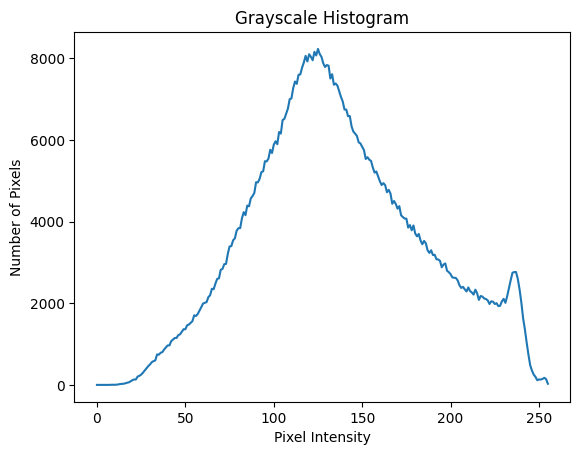

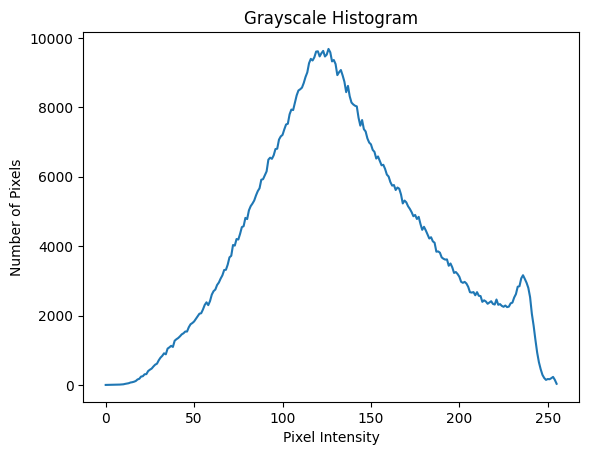

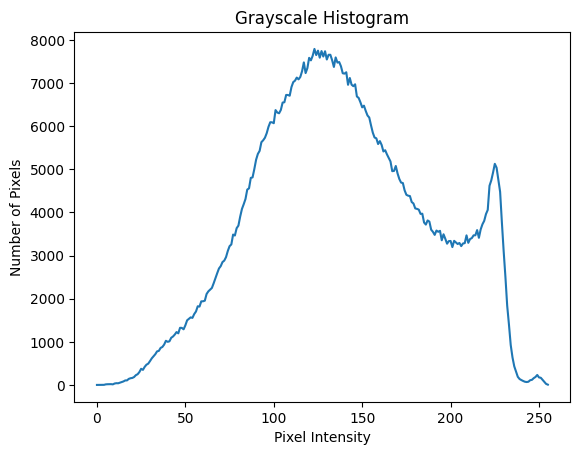

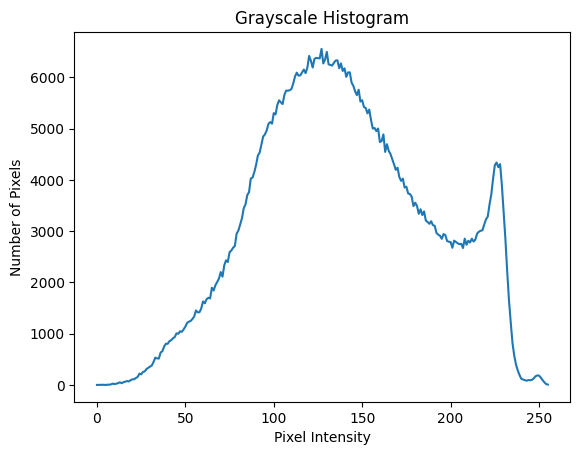

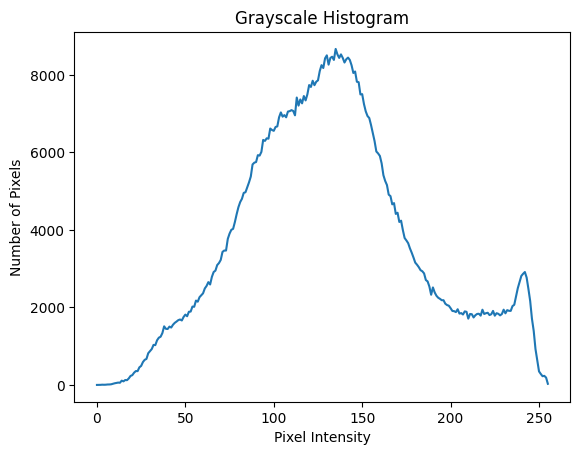

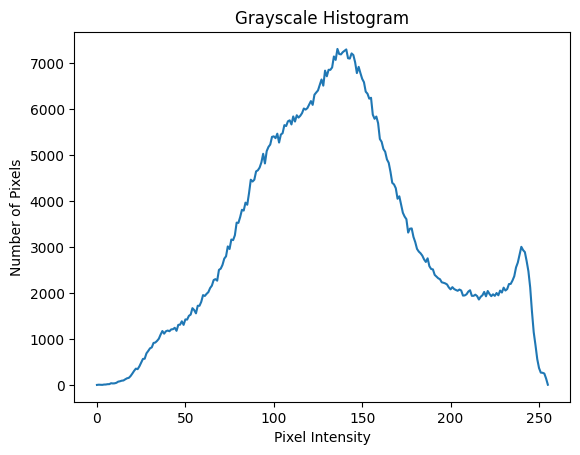

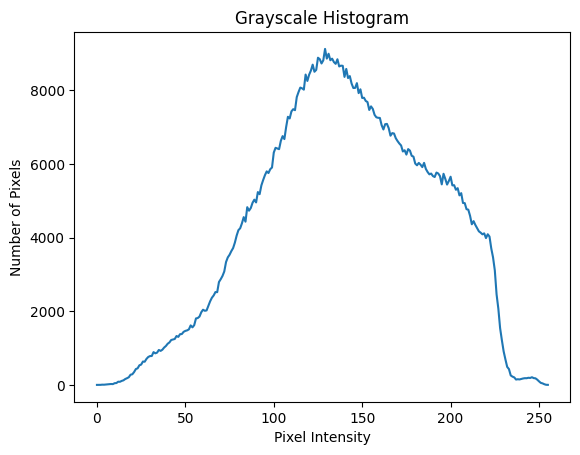

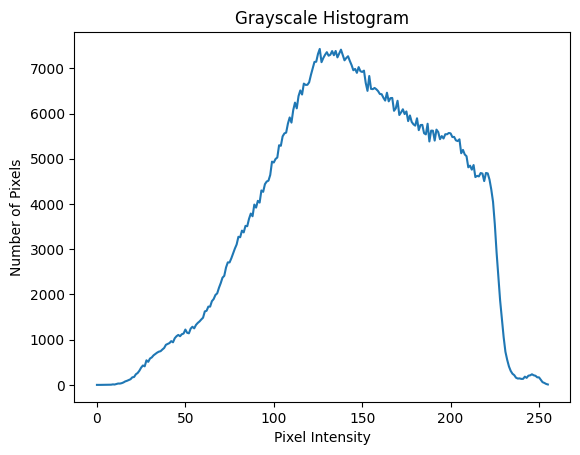

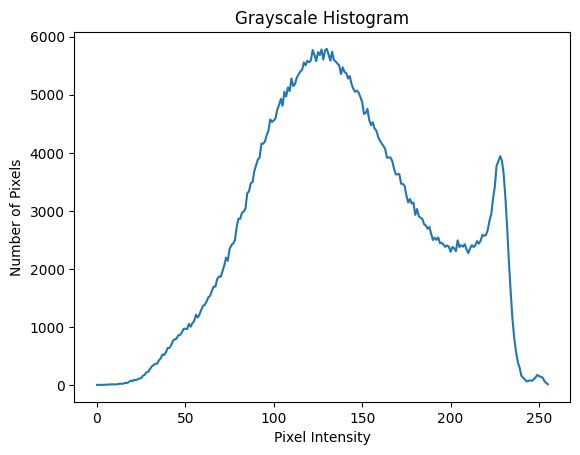

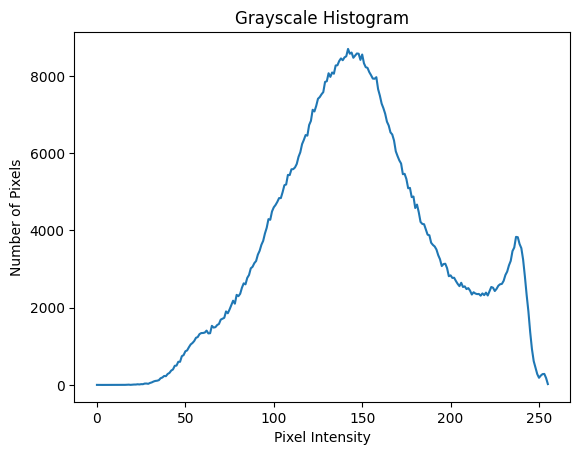

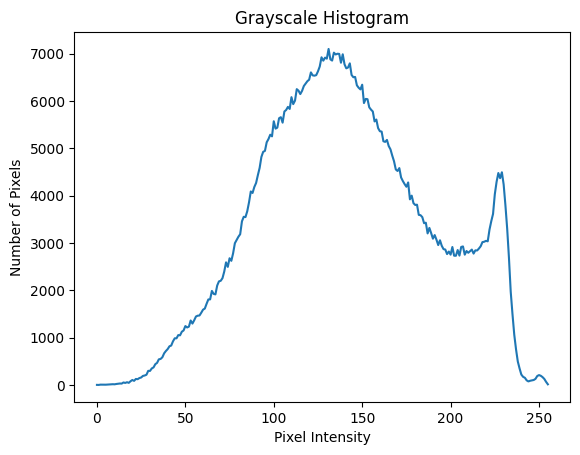

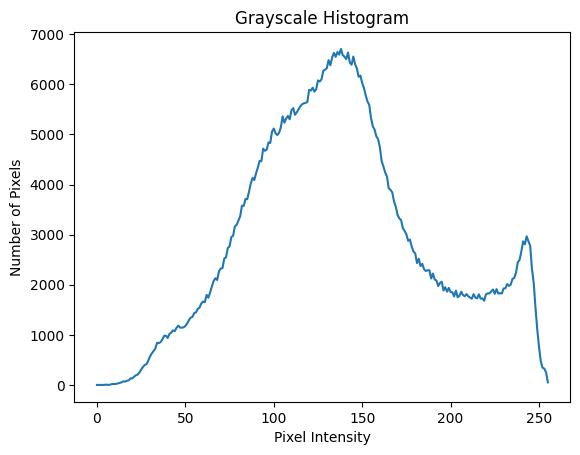

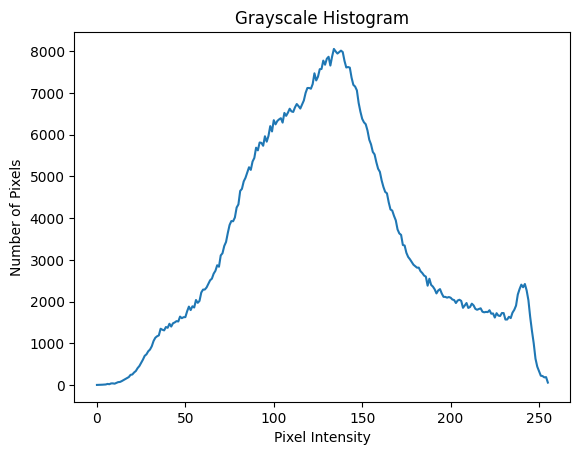

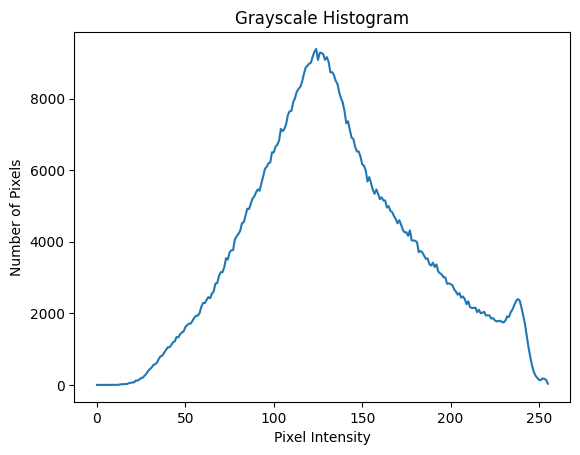

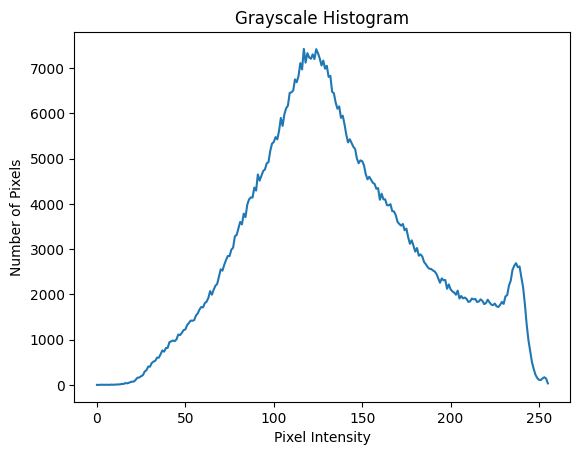

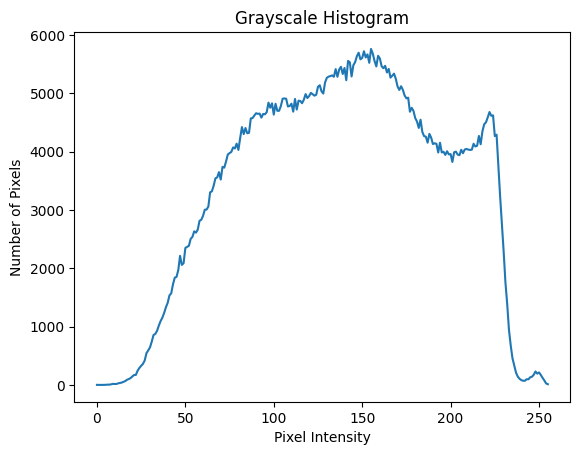

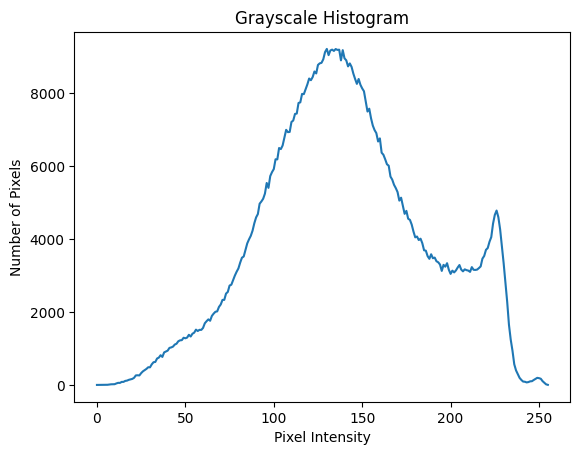

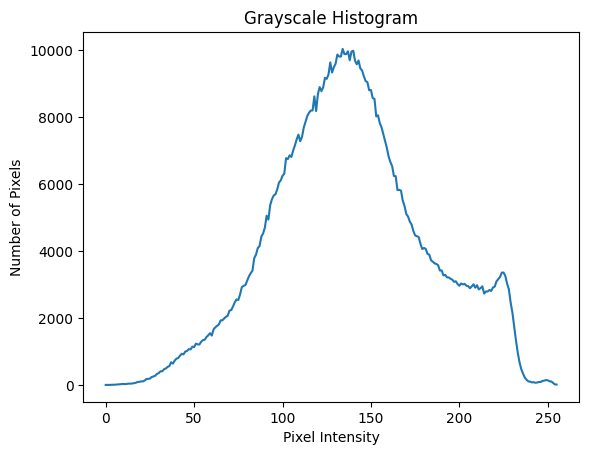

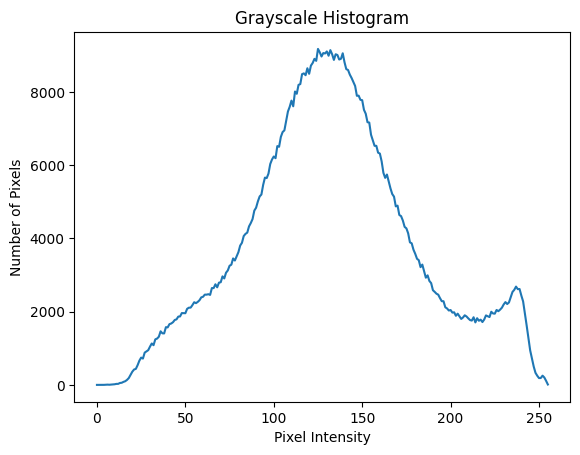

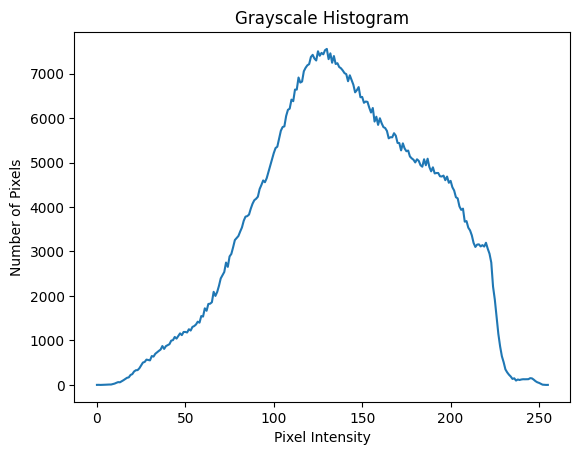

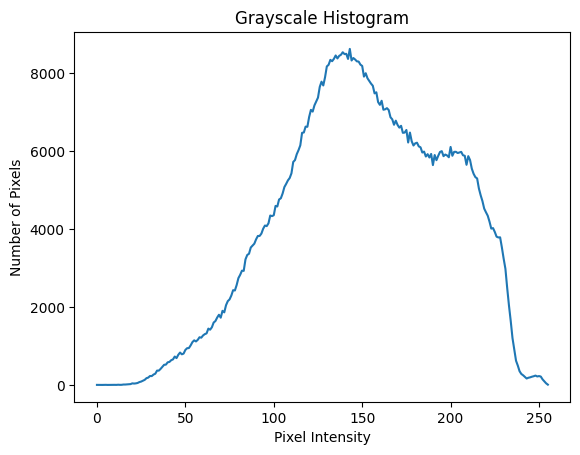

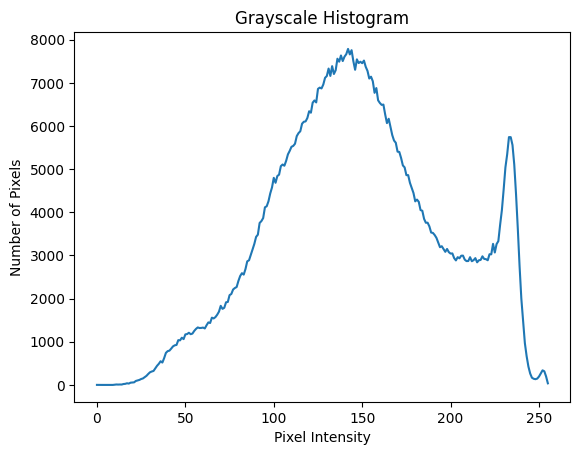

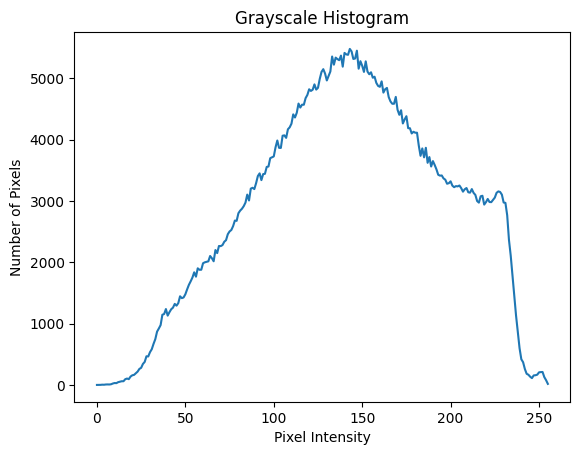

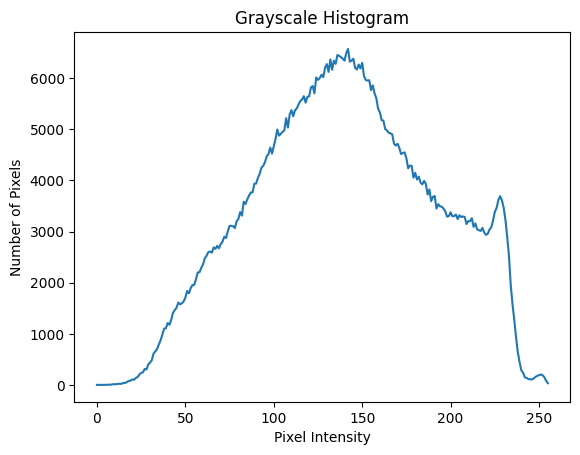

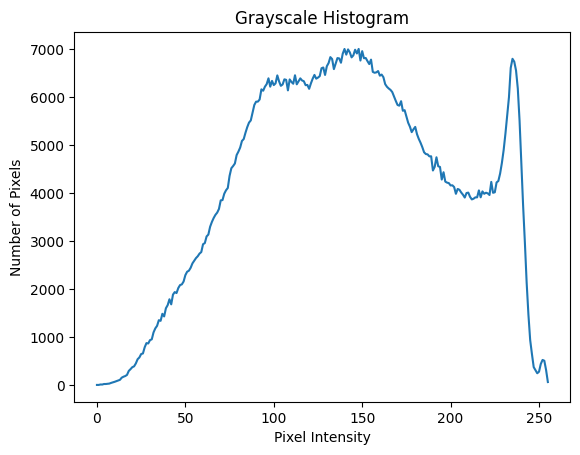

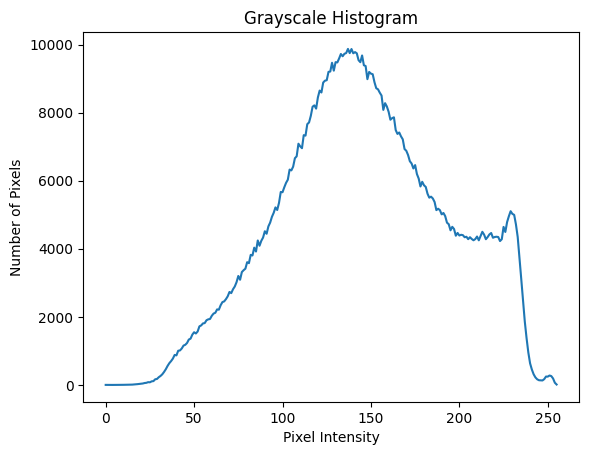

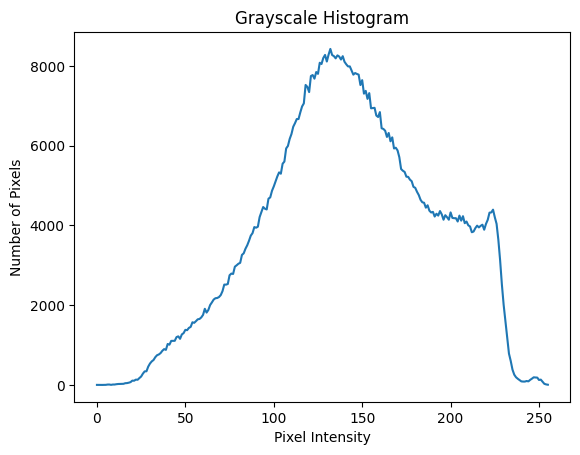

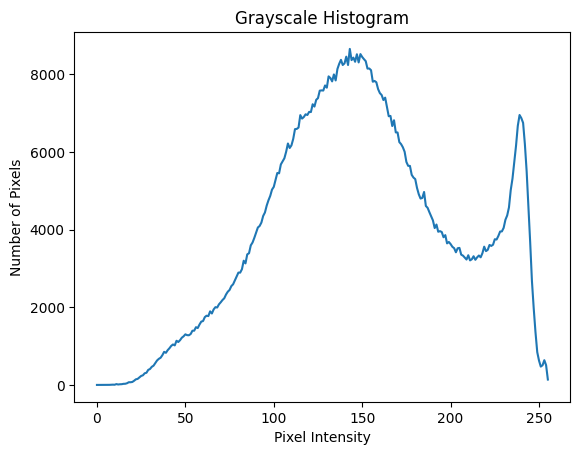

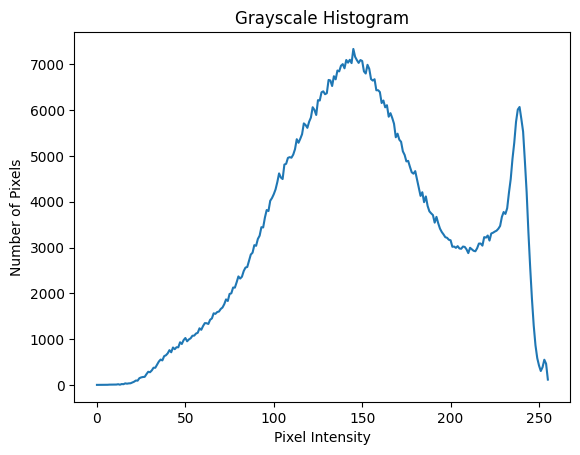

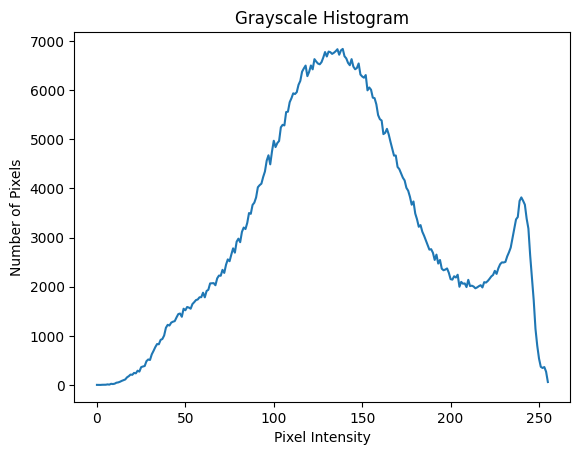

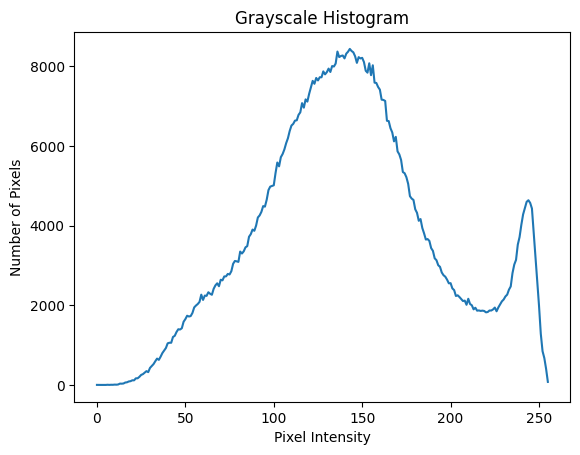

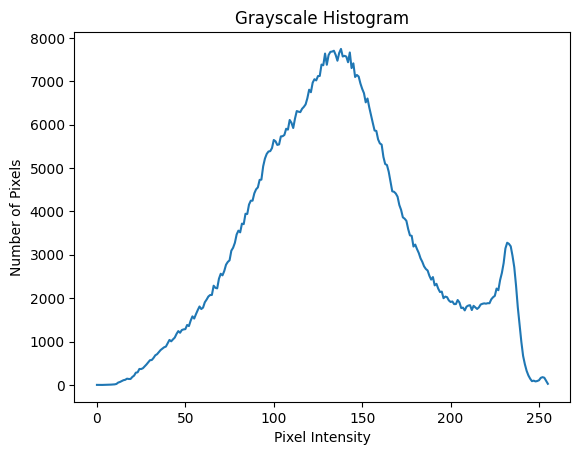

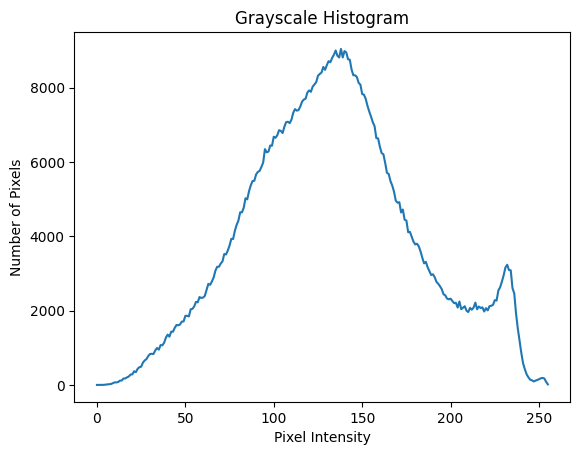

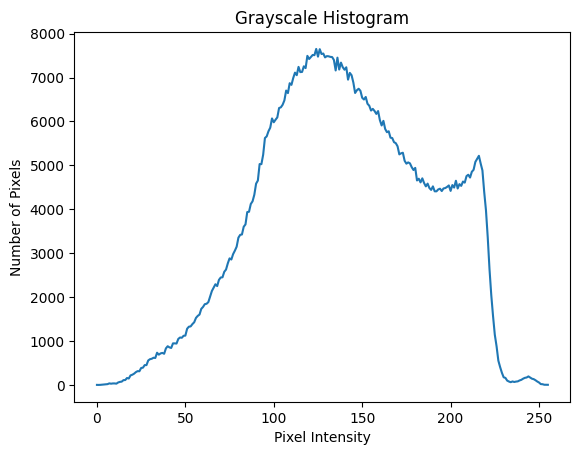

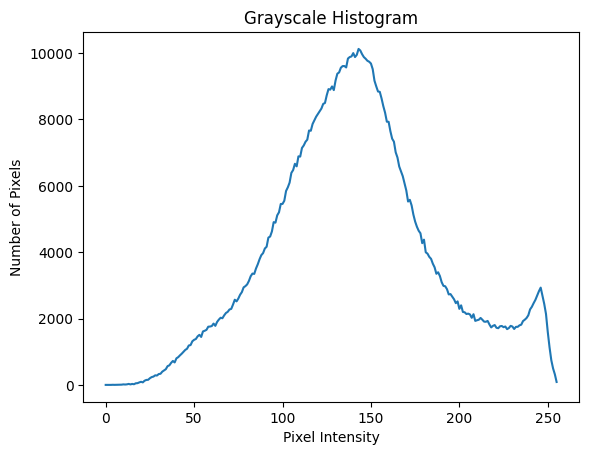

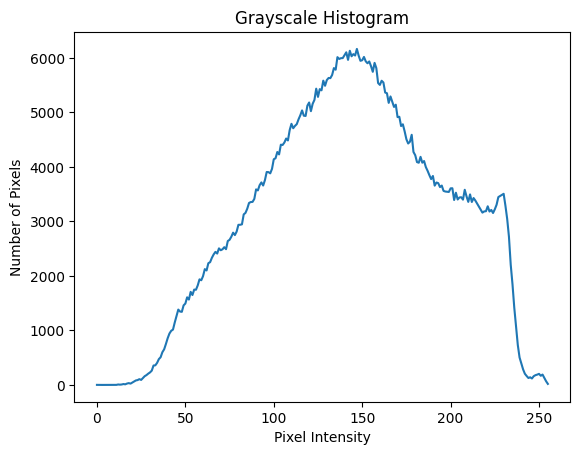

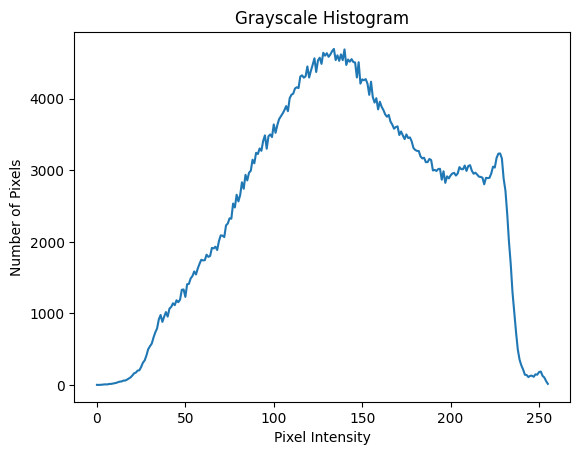

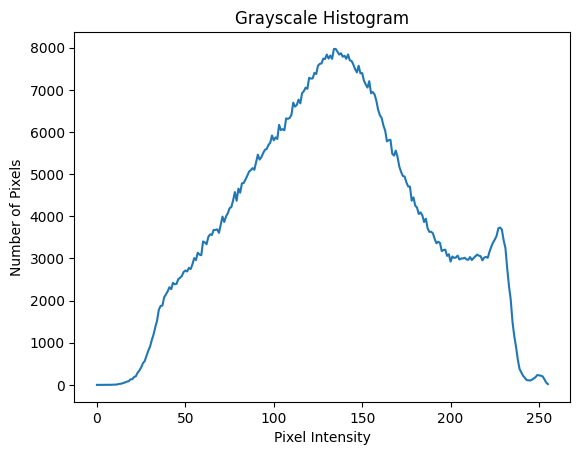

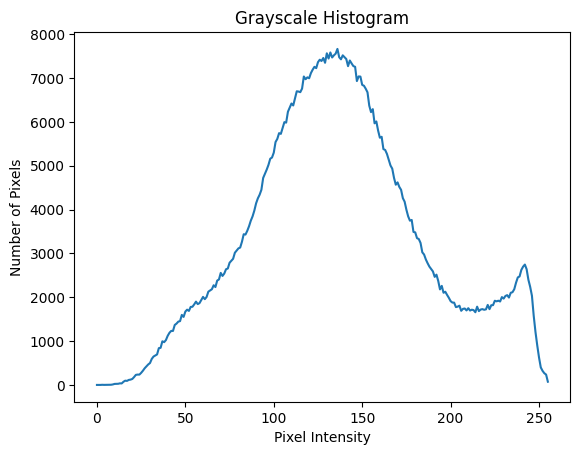

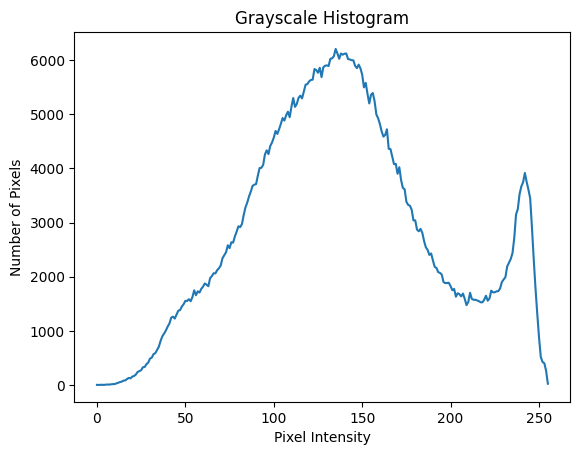

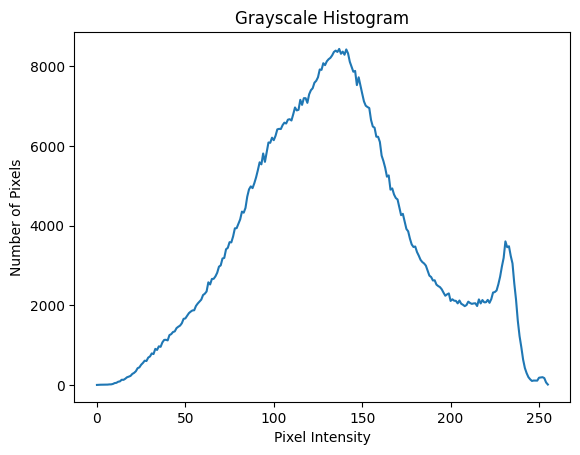

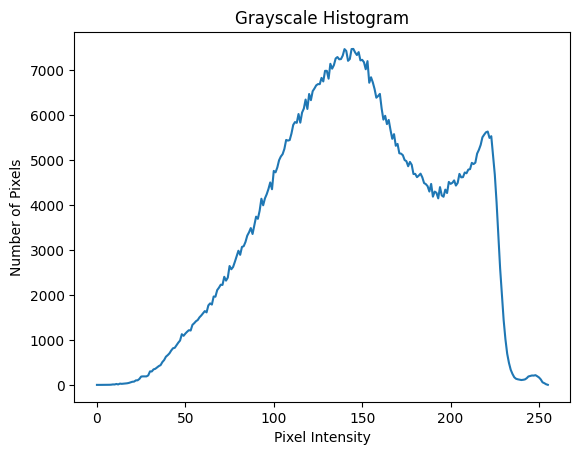

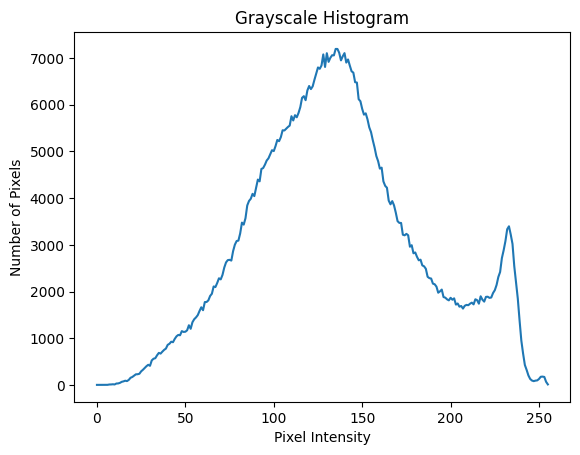

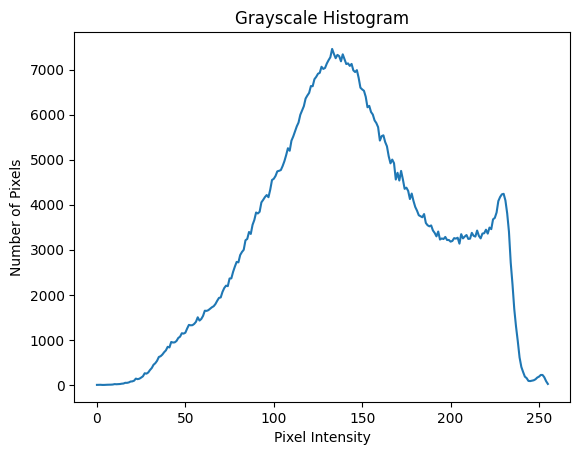

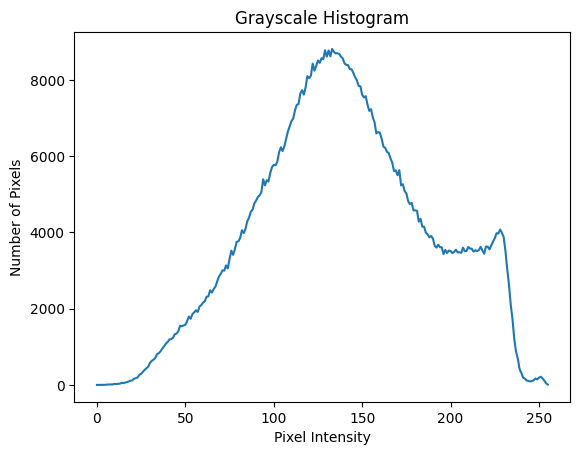

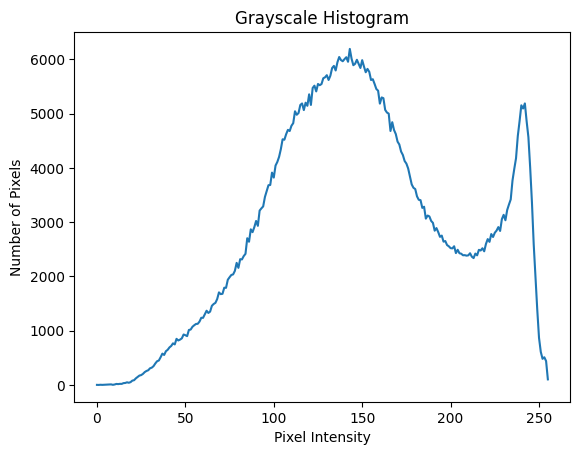

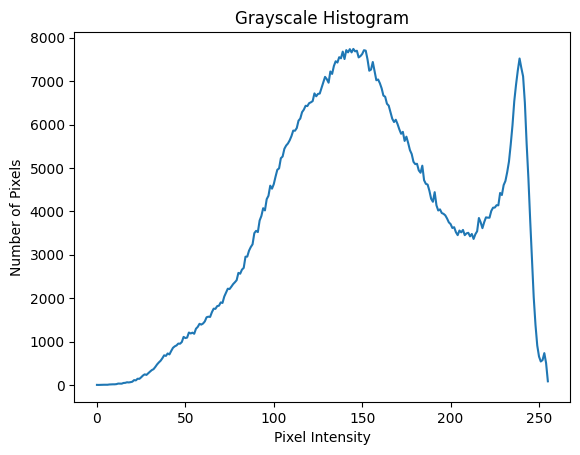

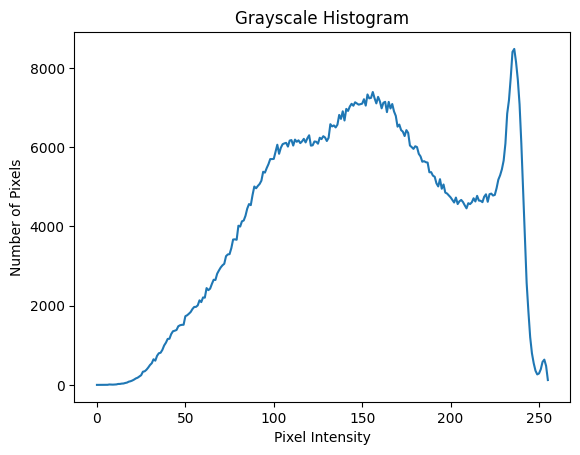

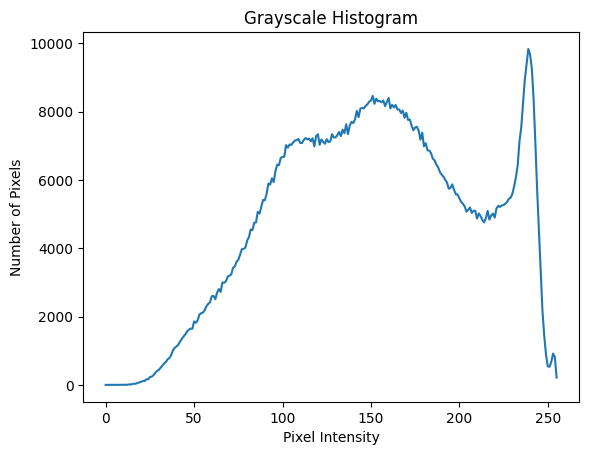

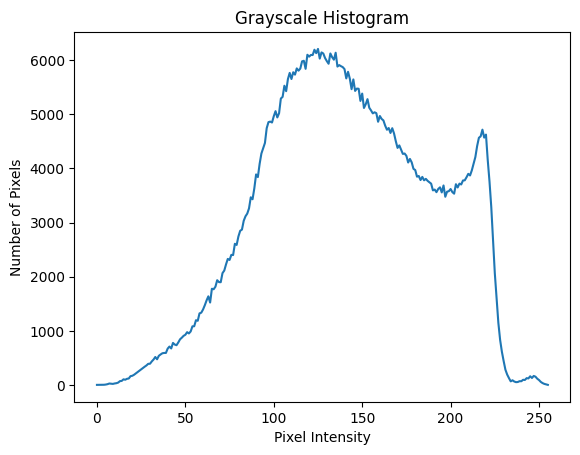

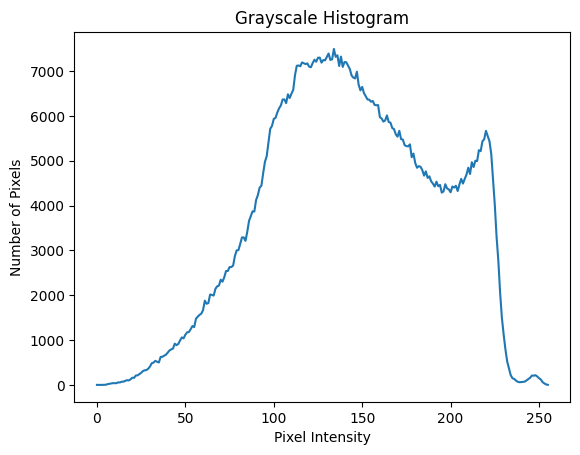

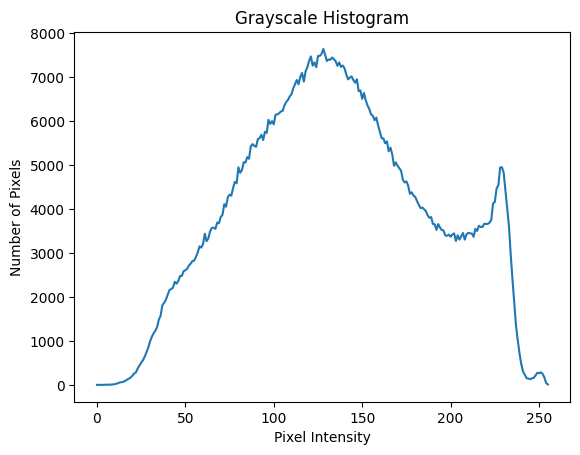

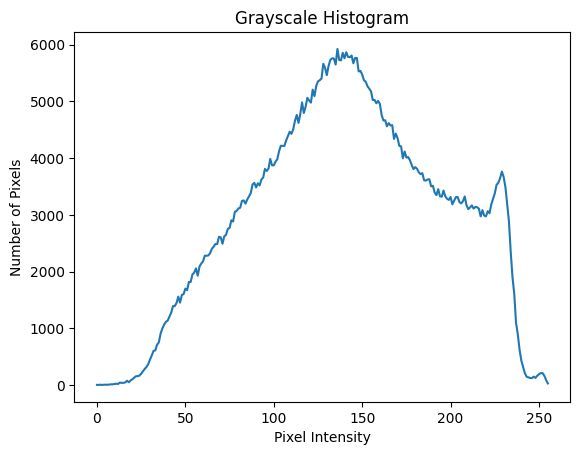

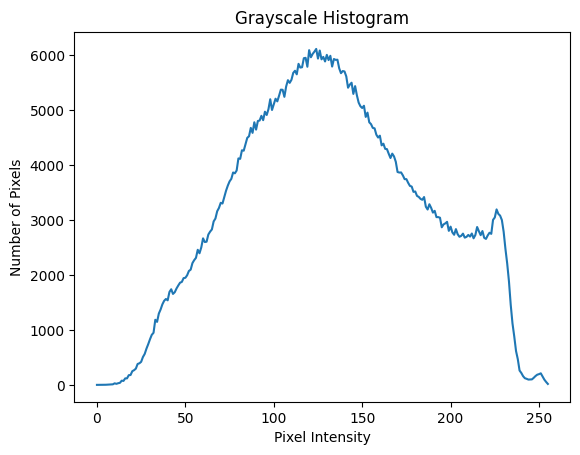

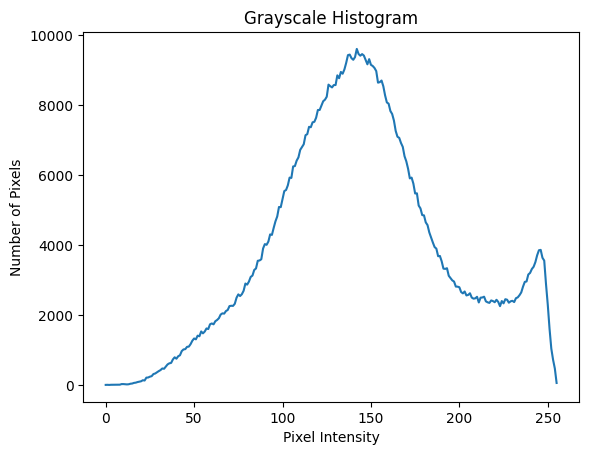

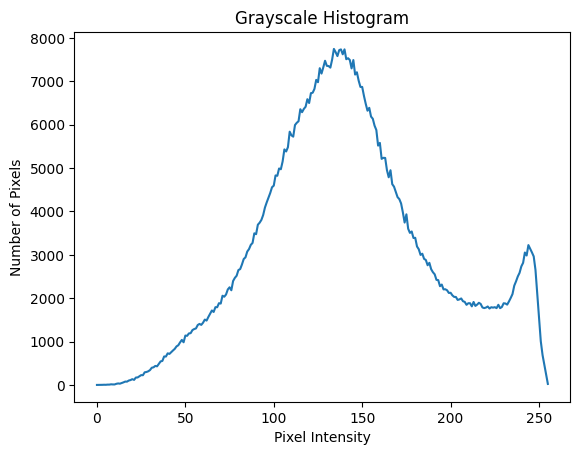

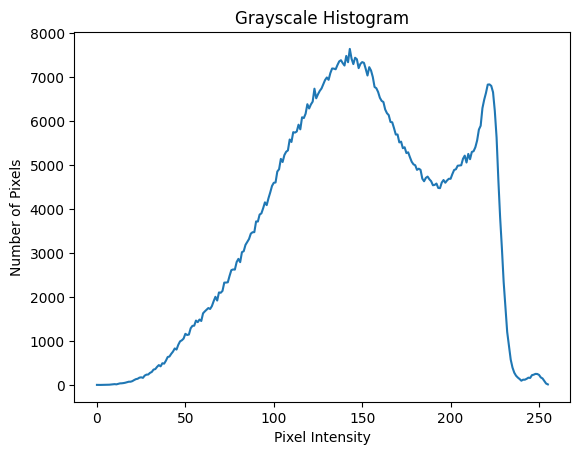

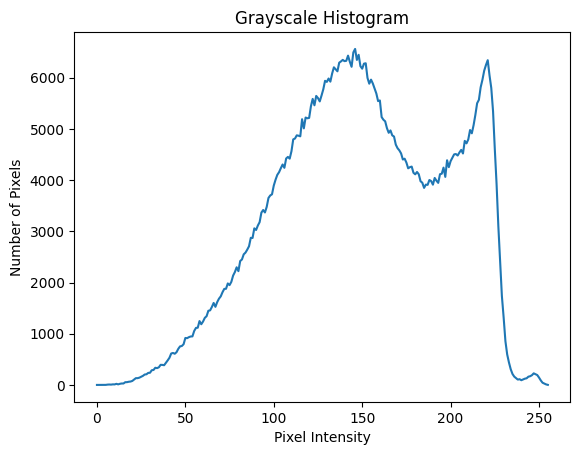

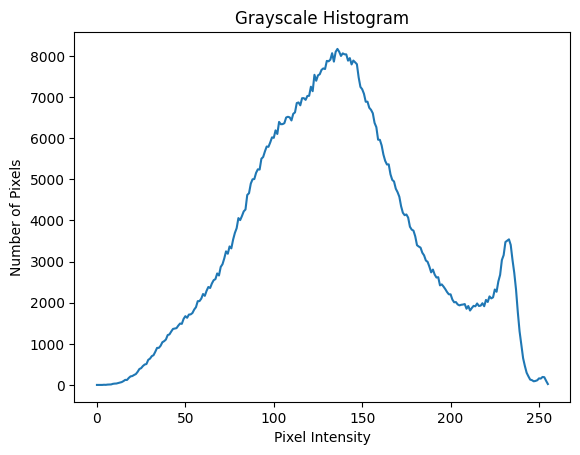

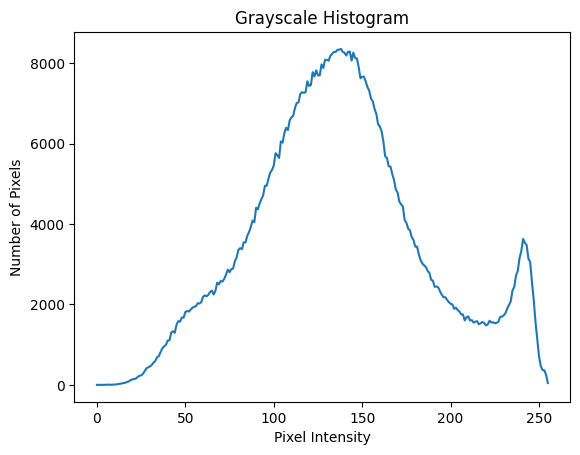

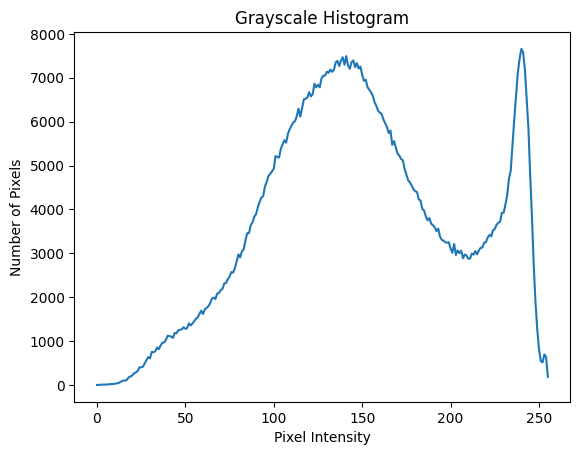

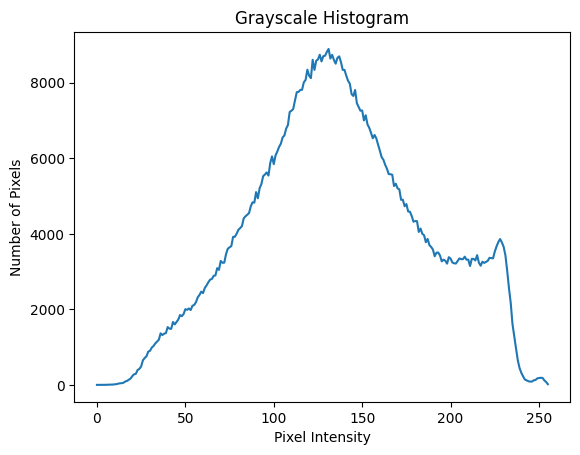

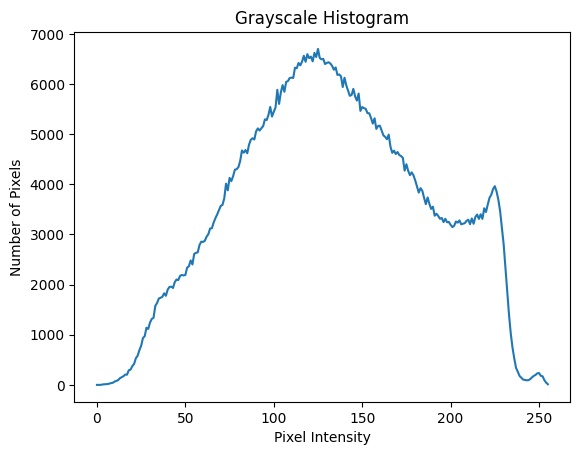

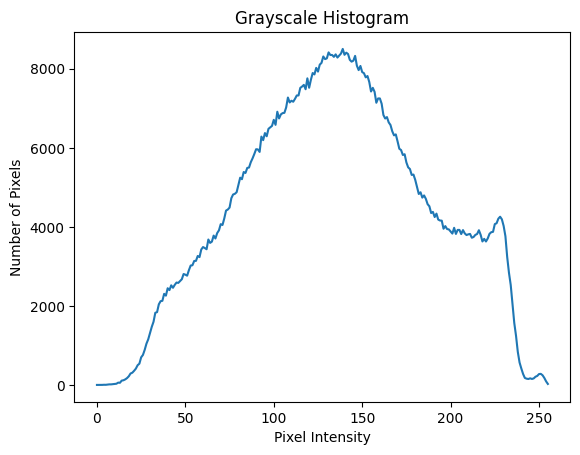

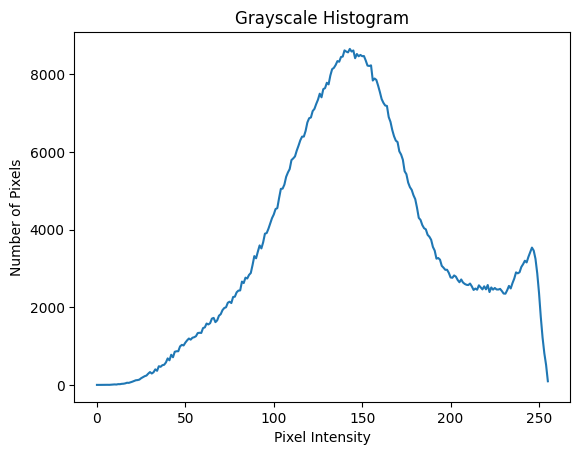

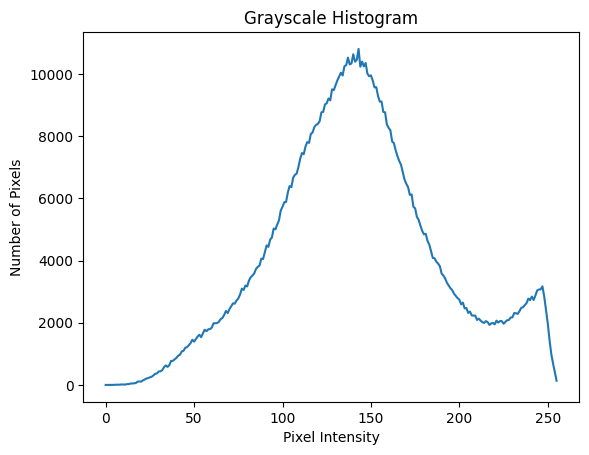

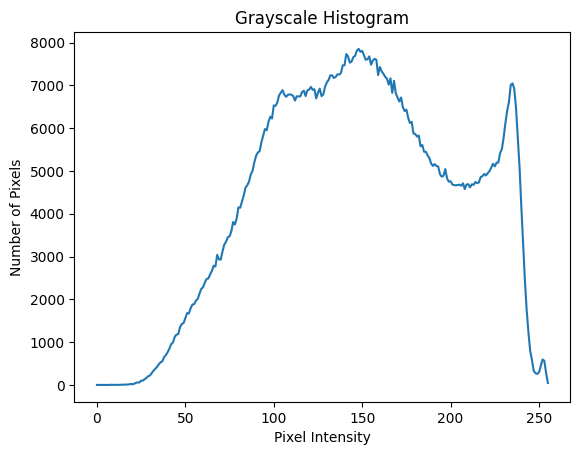

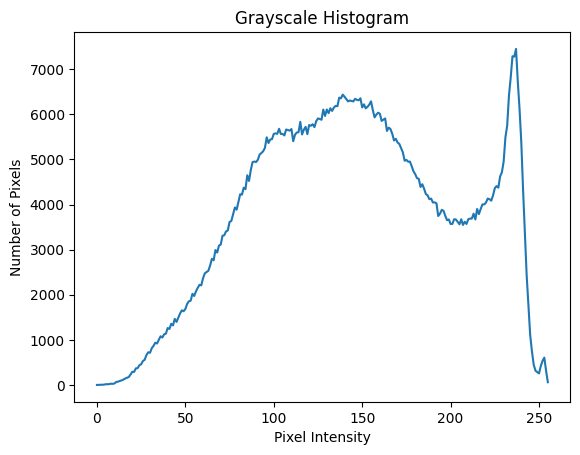

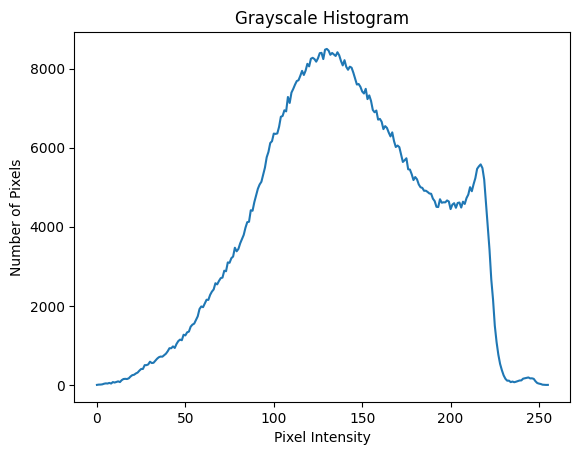

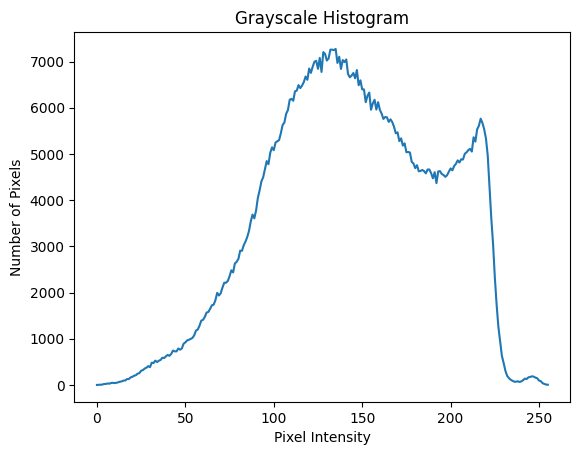

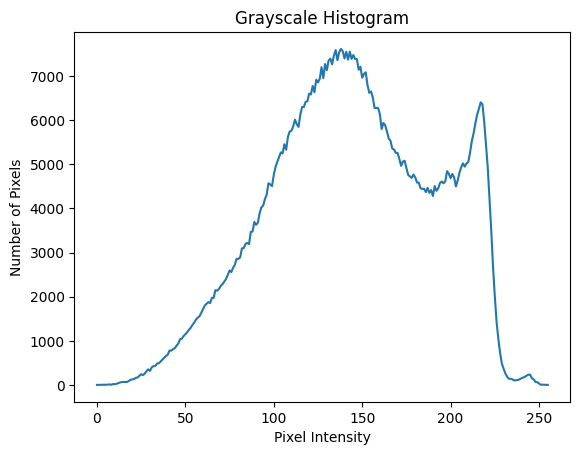

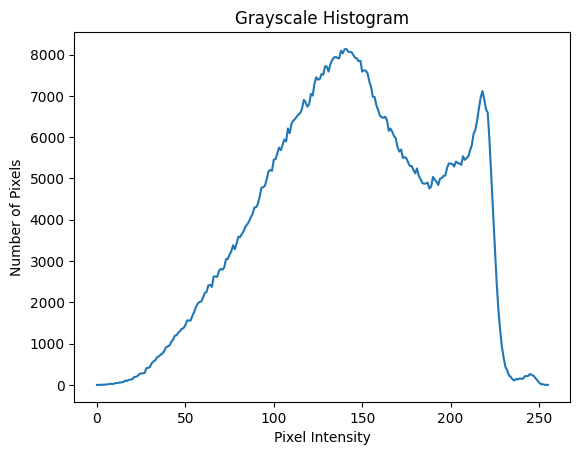

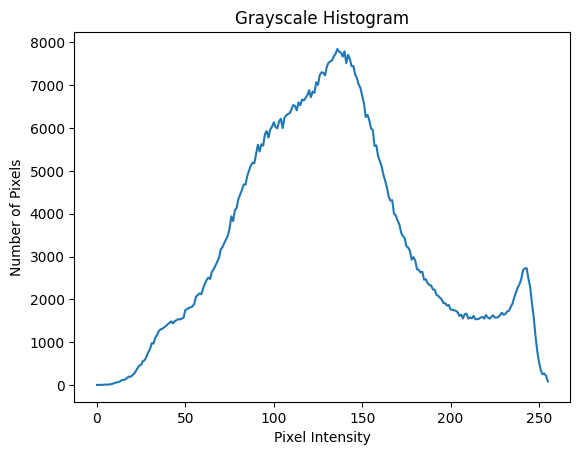

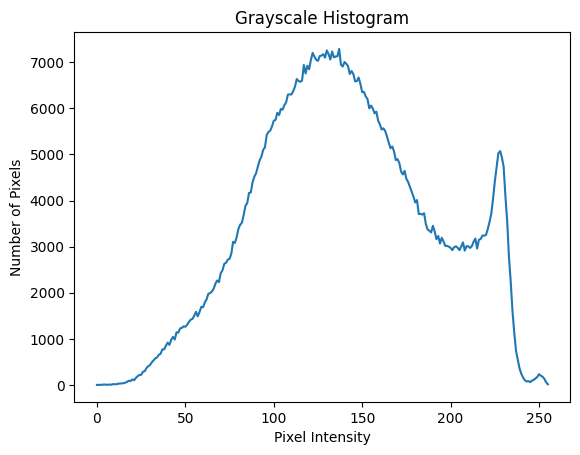

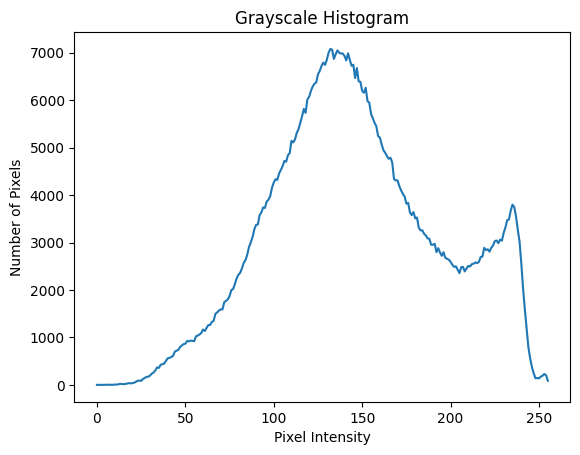

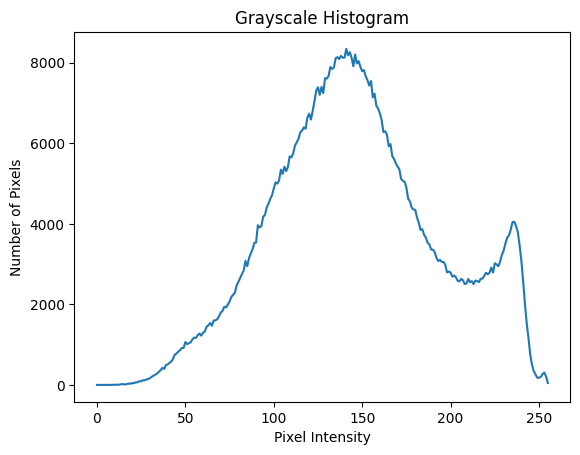

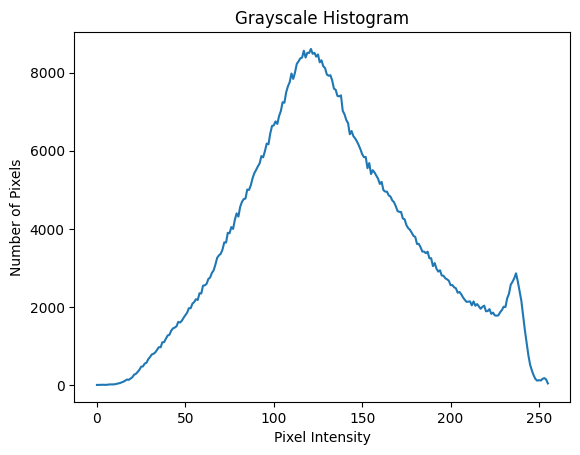

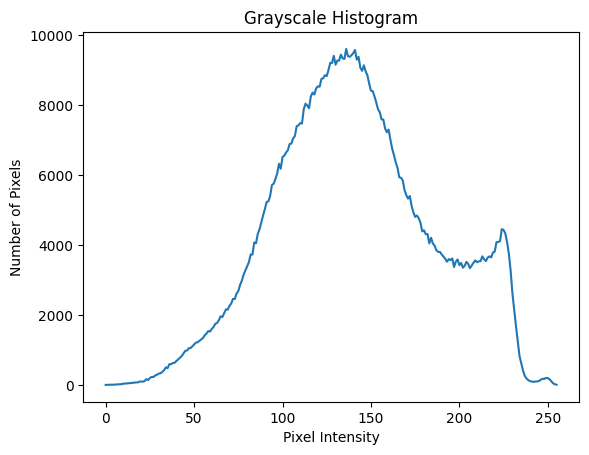

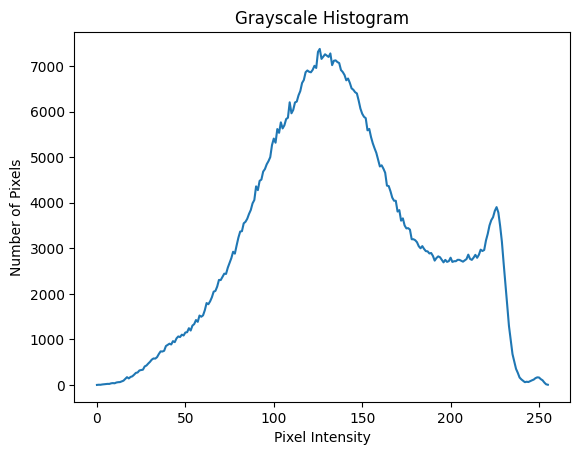

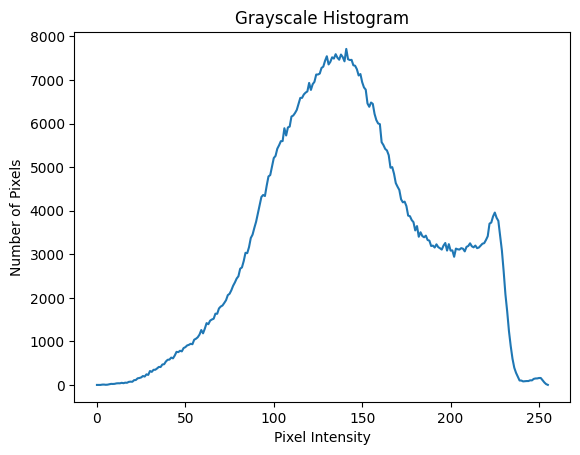

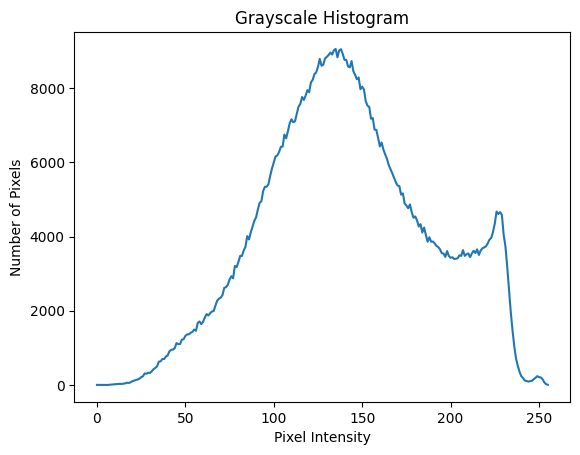

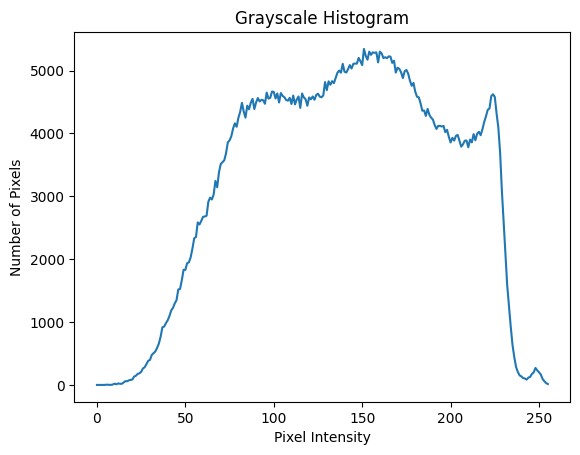

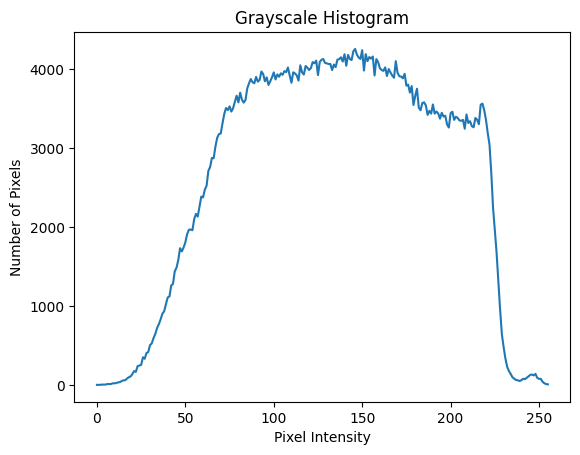

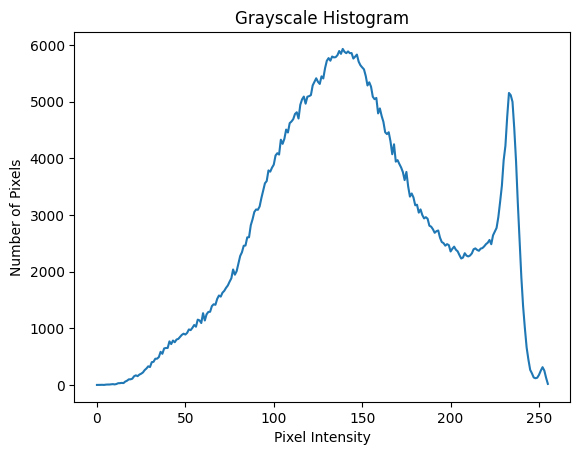

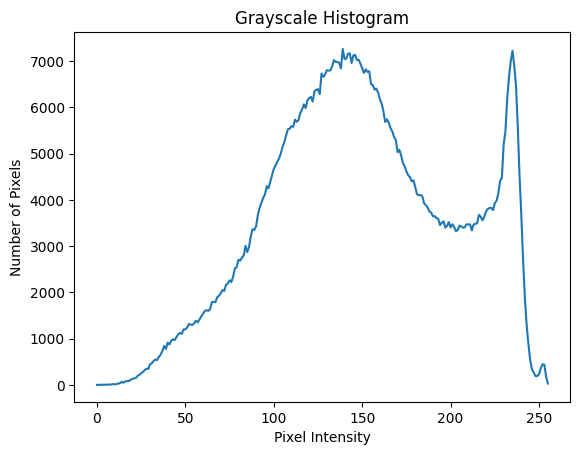

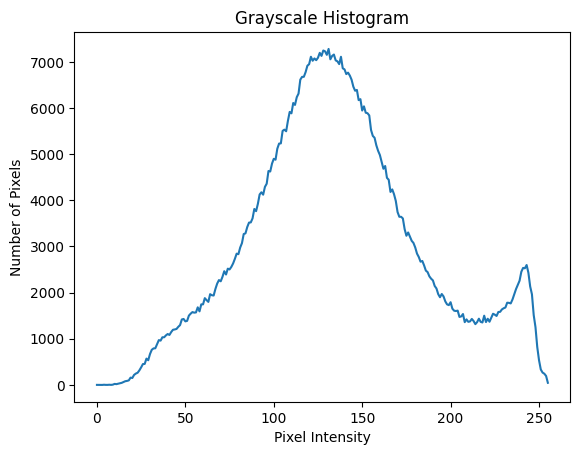

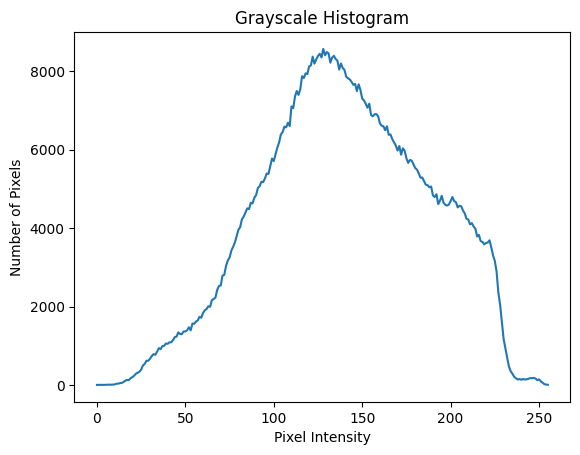

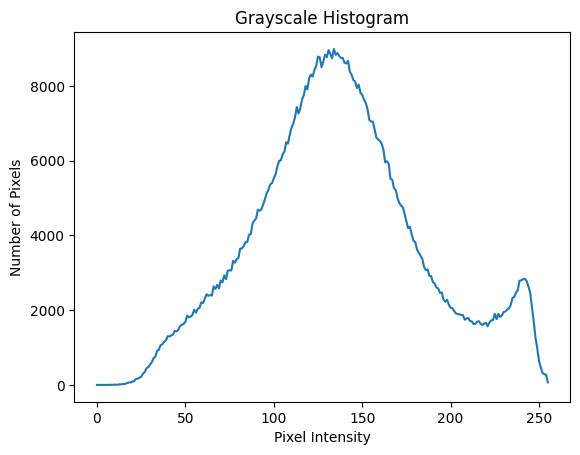

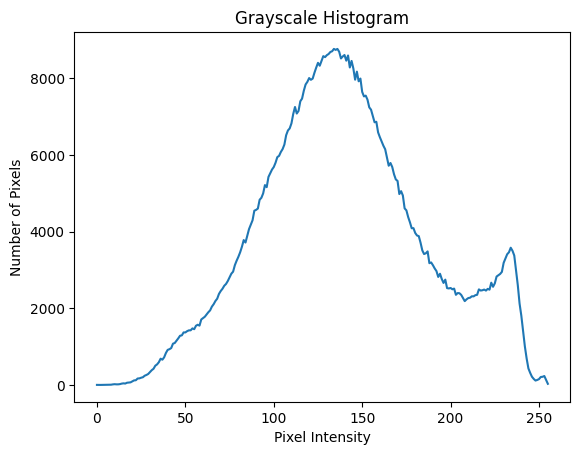

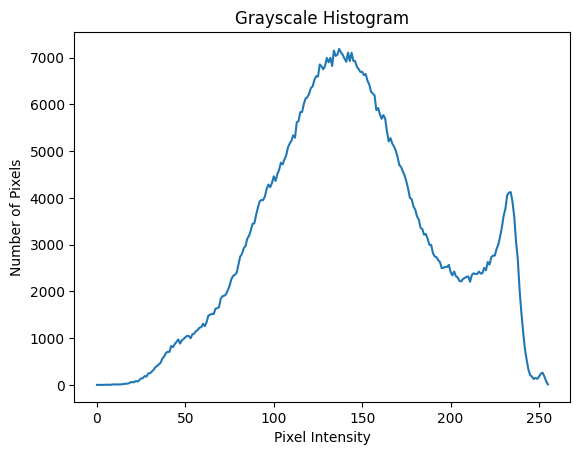

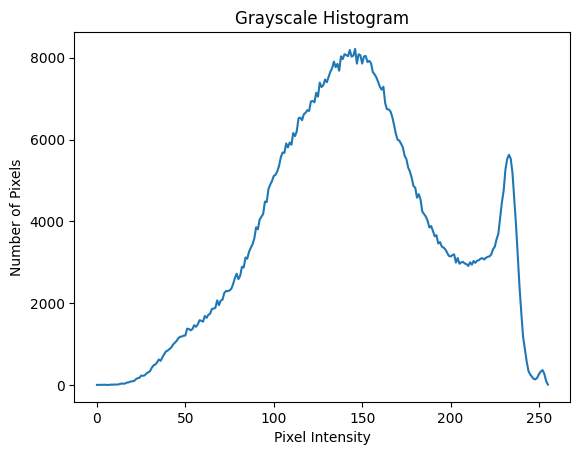

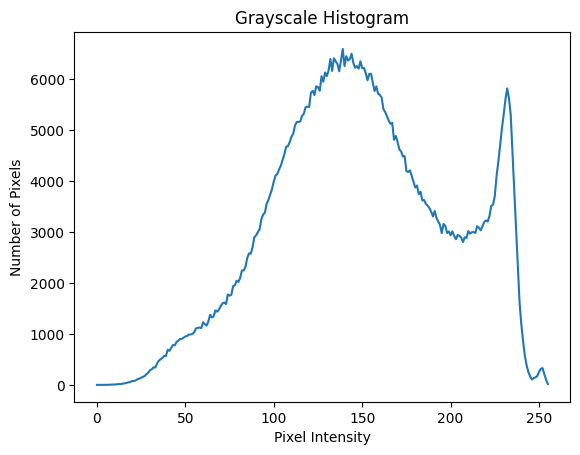

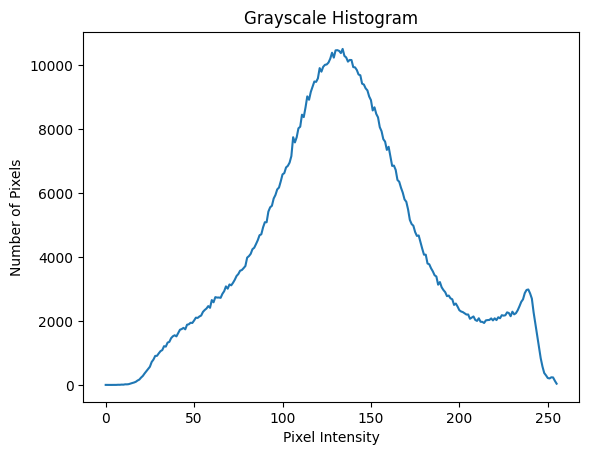

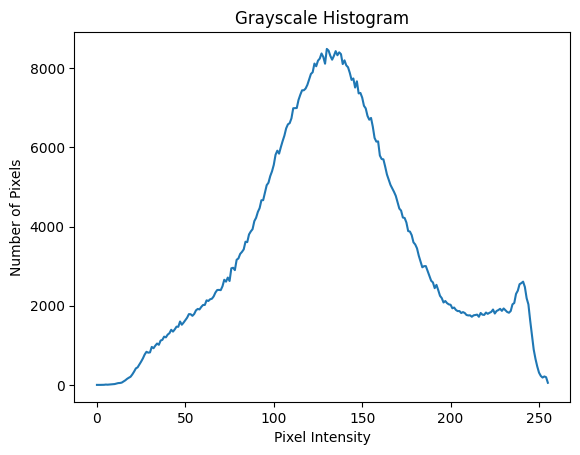

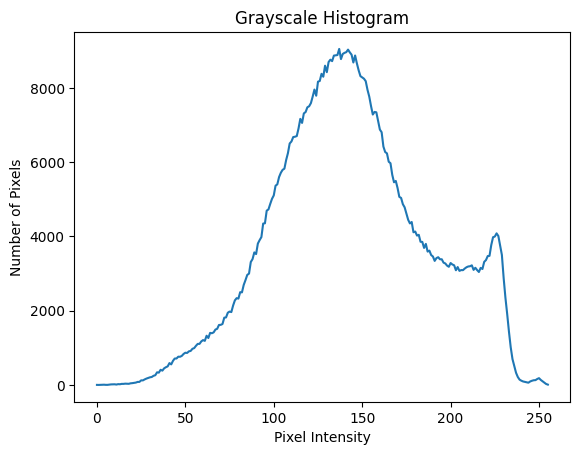

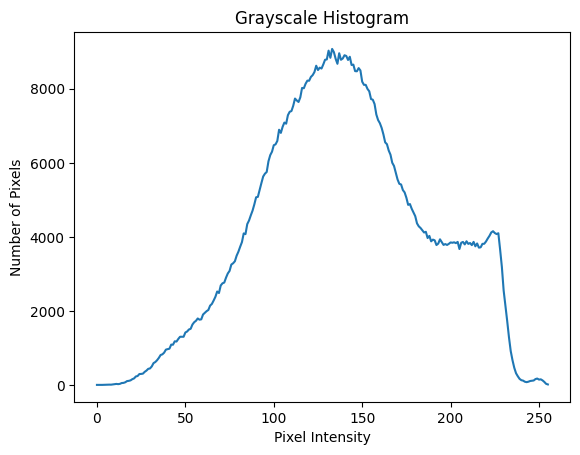

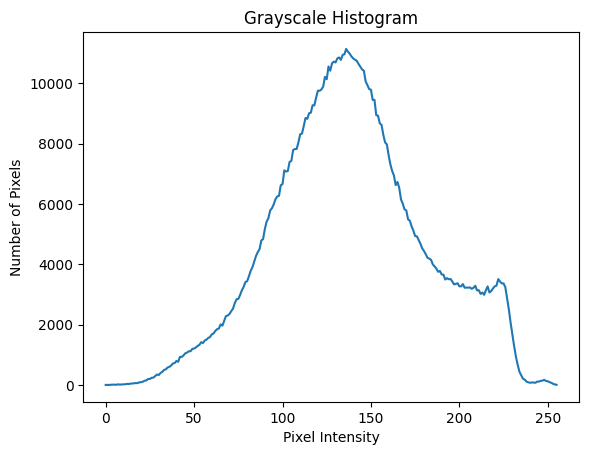

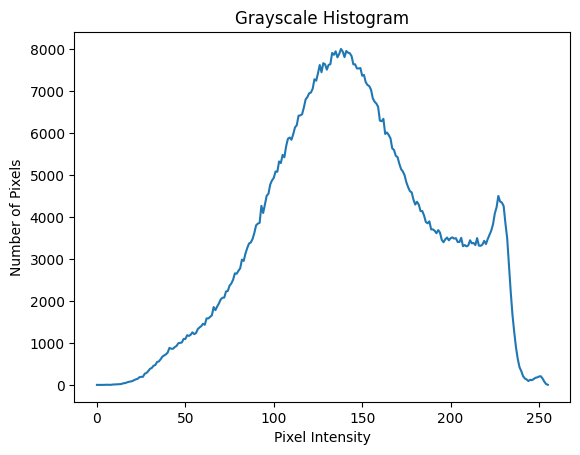

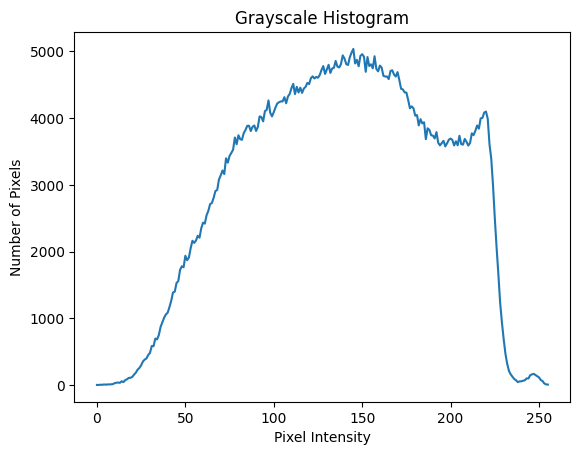

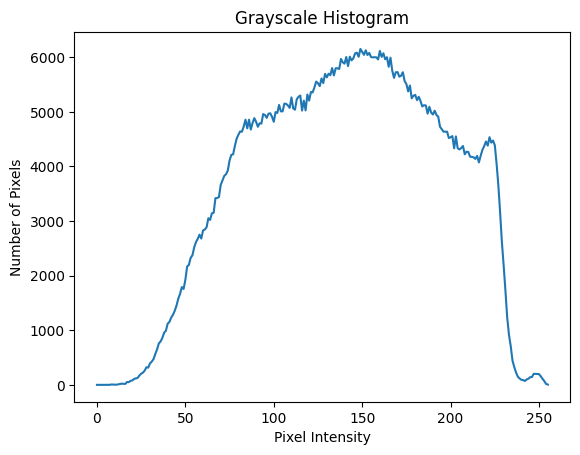

In [4]:
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import noisereduce
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display
import torch
import torchaudio
import torchaudio.transforms as transforms
import torchaudio.functional as F

from PIL import Image
import skimage.io
import cv2


directory = '../spectrograms/'
wav_dir = '../daps/cleanraw/'


def extract_from_filename(filename):
    parts = filename.split('_')
    speaker_id = parts[0]
    script_id = parts[1]
    return speaker_id, script_id
#TODO why second empty
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    print(plt.subplots(num_channels, 1))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        # axes[c].set_xlim([0, 30])
    figure.suptitle("waveform")

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        # axes[c].set_xlim([0, 15])
        # axes[c].set_ylim([0, 1500])
    figure.suptitle(title)        

class_one = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
data = []

for filename in os.listdir(directory):
    if filename.startswith('.'):
        continue
    if filename.endswith('.png'):
        filepath = os.path.join(directory, filename)
        
        try:
            speaker_id, script_id = extract_from_filename(filename)
            # samples = waveform.numpy().flatten()

            is_class_one = any(s in filepath for s in class_one)

            img = cv2.imread(filepath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
            
            plt.plot(hist)
            # label the x-axis
            plt.xlabel('Pixel Intensity')
            # label the y-axis
            plt.ylabel('Number of Pixels')
            # display the title
            plt.title('Grayscale Histogram')
            
            plt.show()
            

            # dest1 = '../sliced_spectograms/1'
            # dest2 = '../sliced_spectograms/0'

            # if is_class_one:
            #     os.rename(filepath,os.path.join(dest1,filename))
            # else:
            #     os.rename(filepath,os.path.join(dest2,filename))
            
            # duration = waveform.shape[1] / sample_rate
            # rms_energy = np.sqrt(np.mean(samples**2))
            # zcr = librosa.feature.zero_crossing_rate(samples)[0].mean()
            # spectral_centroid = librosa.feature.spectral_centroid(y=samples, sr=sample_rate)[0].mean()
            # spectral_bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sample_rate)[0].mean()
            # mfccs = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13).mean(axis=1)
            
            # frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
            # mean_spectrogram = np.mean(spectrogram)
            # std_spectrogram = np.std(spectrogram)
            
            # dominant_freq = frequencies[np.argmax(spectrogram, axis=0)].mean()
    
            # data.append({
            #     'filename': filename,
            #     'speaker_id': speaker_id,
            #     'script_id': script_id,
            #     'audio_type': audio_type,
            #     'duration': duration,
            #     'sample_rate': sample_rate,
            #     'rms_energy': rms_energy,
            #     'zero_crossing_rate': zcr,
            #     'spectral_centroid': spectral_centroid,
            #     'spectral_bandwidth': spectral_bandwidth,
            #     'mfccs': mfccs.tolist(),
            #     'mean_spectrogram': mean_spectrogram,
            #     'std_spectrogram': std_spectrogram,
            #     'dominant_freq': dominant_freq
            # })
            #print(data)

            # plot_waveform(waveformt, sr)
            # plt.show()
            # plot_specgram(waveformt, sr)
            # plt.show()
            
        except ValueError as e:
            print(f"Error reading {filename}: {e}")
        except Exception as e:
            print(f"An unexpected error occurred with {filename}: {e}")

#df = pd.DataFrame(data)




In [5]:
import noisereduce


def create_metadata_df(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.startswith('.'):
            continue
        speaker_id, script_id = extract_from_filename(filename)
        filepath = os.path.join(wav_dir,filename)
        y, sr = librosa.load(filepath,sr=None)
        y=noisereduce.reduce_noise(y=y,sr=sr) # reducing noise, without it almost all audio is considered speech with based top_db being 60
        duration = librosa.get_duration(y=y, sr=sr)
        db = librosa.amplitude_to_db(y)
        # print(np.max(abs(db))) #around 80

        non_silent_intervals = librosa.effects.split(y)
    
        # Calculate the talking duration
        talking_duration = sum((end - start) / sr for start, end in non_silent_intervals)   
        silence_duration = duration - talking_duration
        
        data.append({
            'filename': filename,
            'speaker_id': speaker_id,
            'script_id': script_id,
            'is_class_one': any(s in filename for s in class_one),
            'path': filepath,
            'duration': duration,
            'talking_duration': talking_duration,
            'silence_duration': silence_duration,
        })
    return pd.DataFrame(data)

metadata_df = create_metadata_df(wav_dir)
print(metadata_df.head())

                  filename speaker_id script_id  is_class_one  \
0  m2_script5_cleanraw.wav         m2   script5         False   
1  m2_script2_cleanraw.wav         m2   script2         False   
2  f5_script2_cleanraw.wav         f5   script2         False   
3  f5_script5_cleanraw.wav         f5   script5         False   
4  m7_script2_cleanraw.wav         m7   script2         False   

                                       path    duration  talking_duration  \
0  ../daps/cleanraw/m2_script5_cleanraw.wav  155.031859        118.770068   
1  ../daps/cleanraw/m2_script2_cleanraw.wav  187.426395        142.849161   
2  ../daps/cleanraw/f5_script2_cleanraw.wav  165.362676        130.275556   
3  ../daps/cleanraw/f5_script5_cleanraw.wav  139.538753        109.888435   
4  ../daps/cleanraw/m7_script2_cleanraw.wav  167.896236        131.773243   

   silence_duration  
0         36.261791  
1         44.577234  
2         35.087120  
3         29.650317  
4         36.122993  


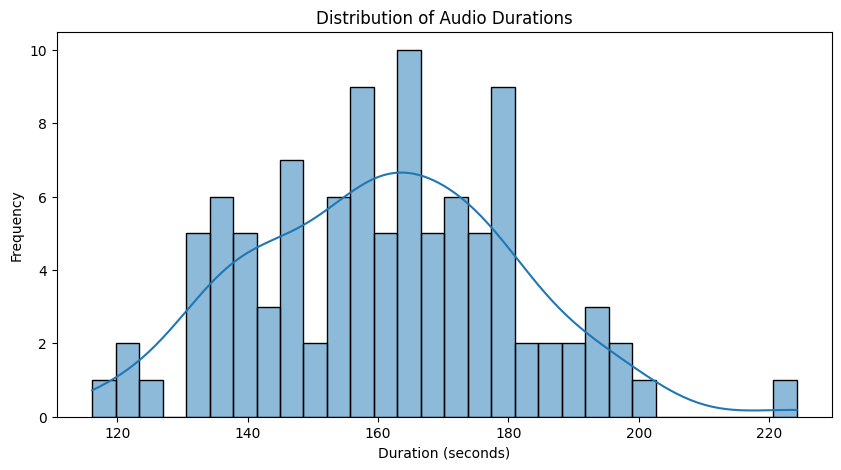

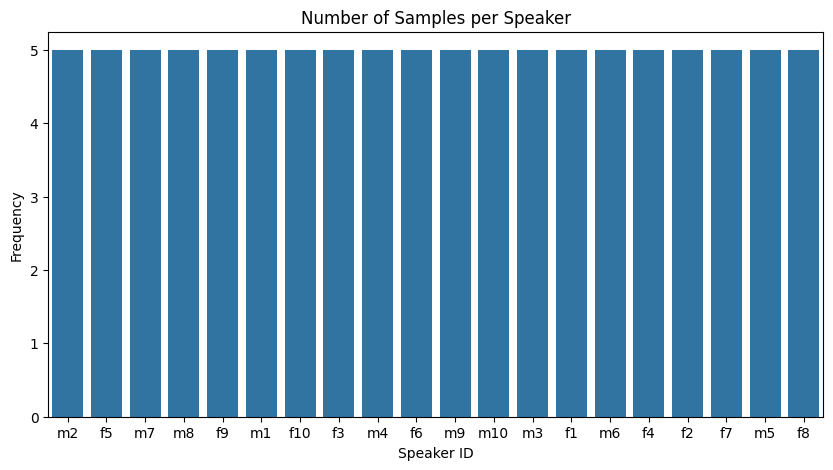

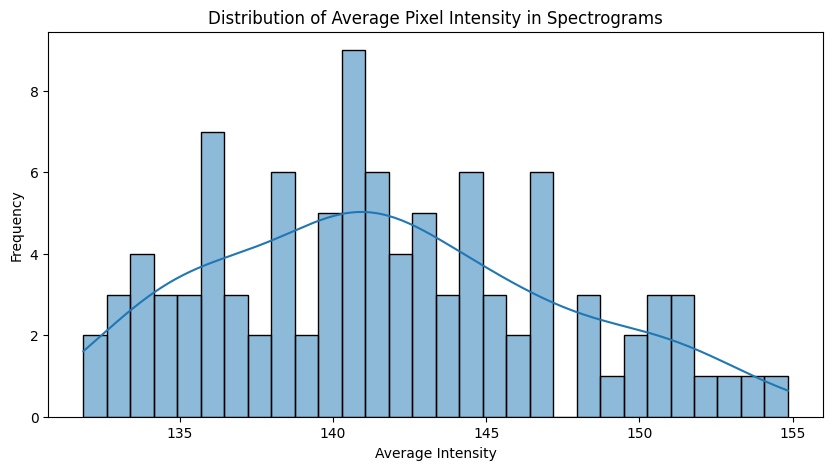

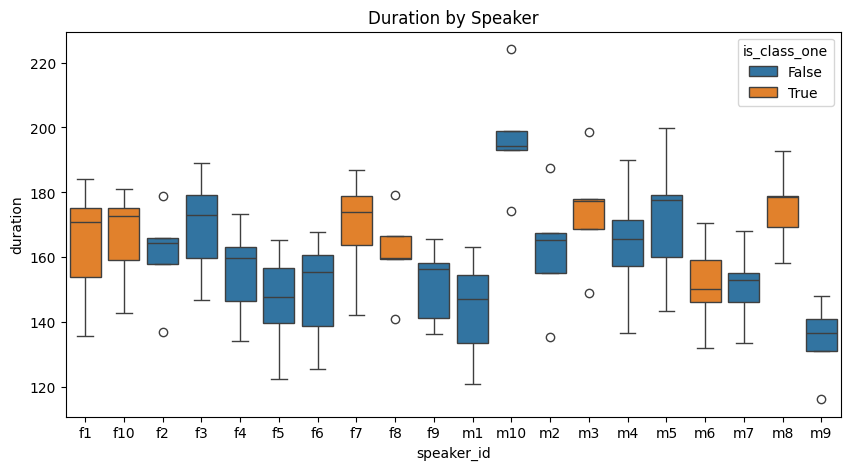

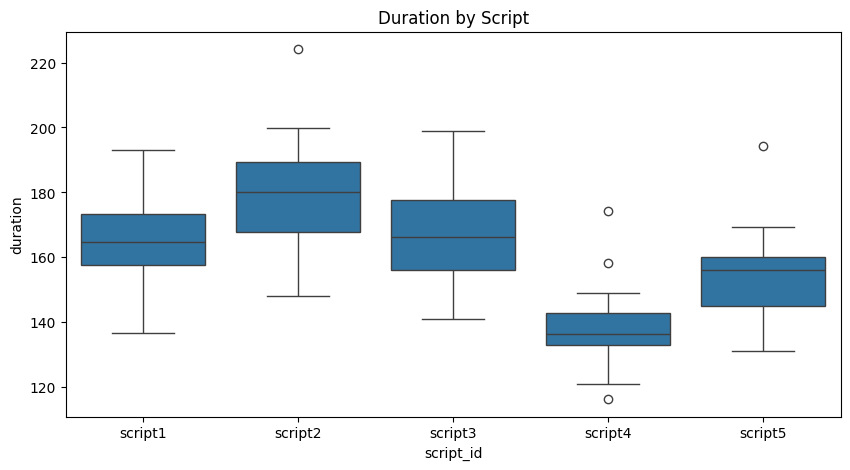

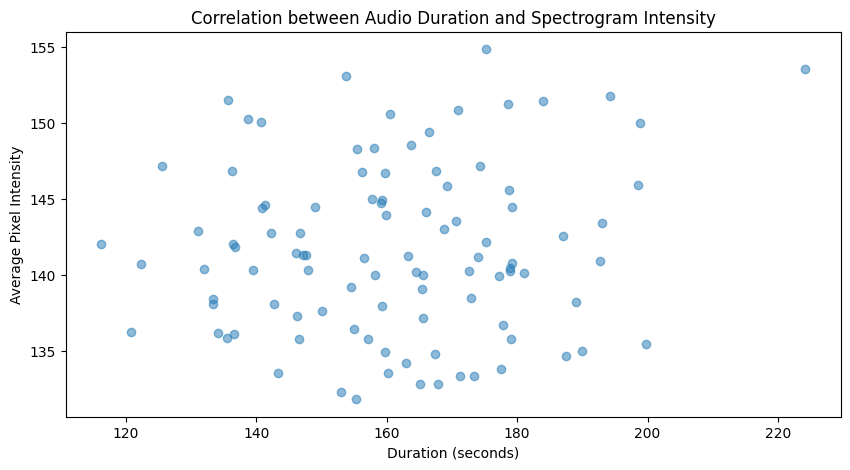

/tmp/ipykernel_260606/2942838779.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  p = metadata_df.pivot(index='speaker_id', columns='script_id', values='avg_intensity').fillna(0)


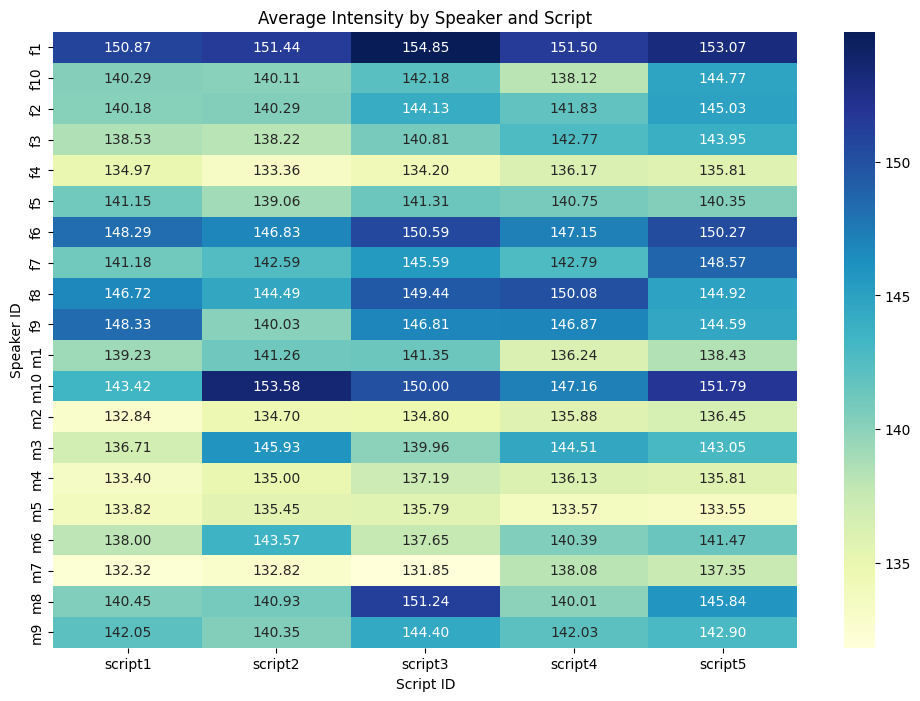

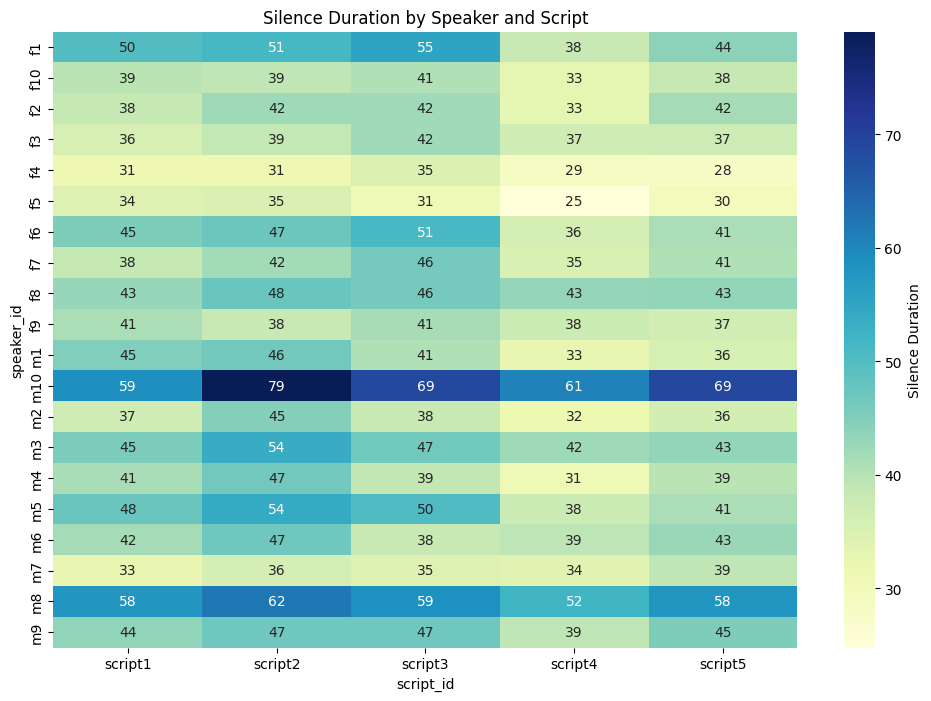

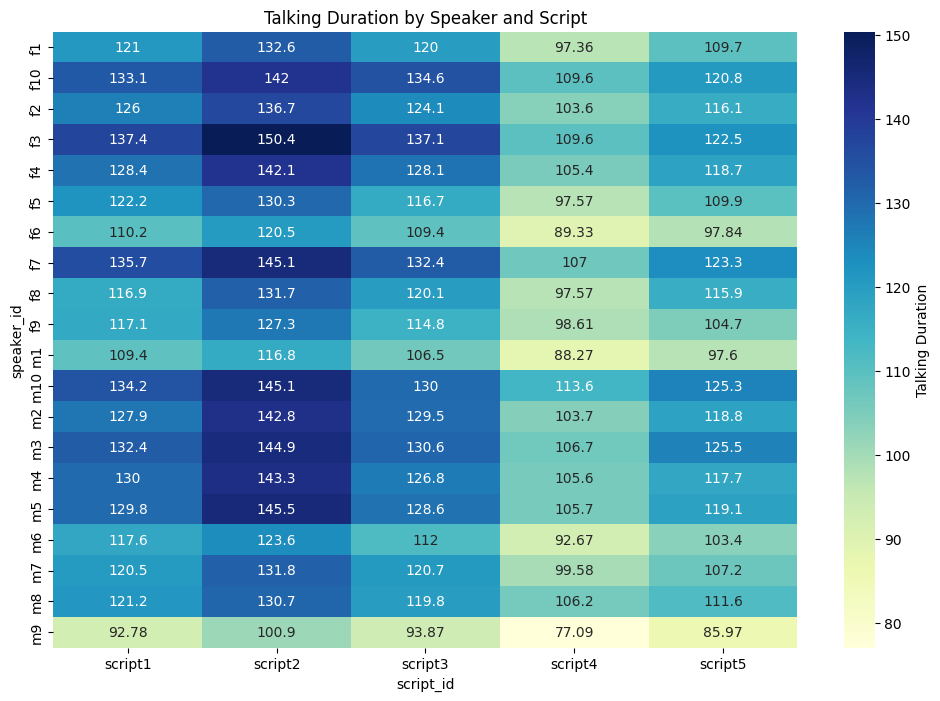

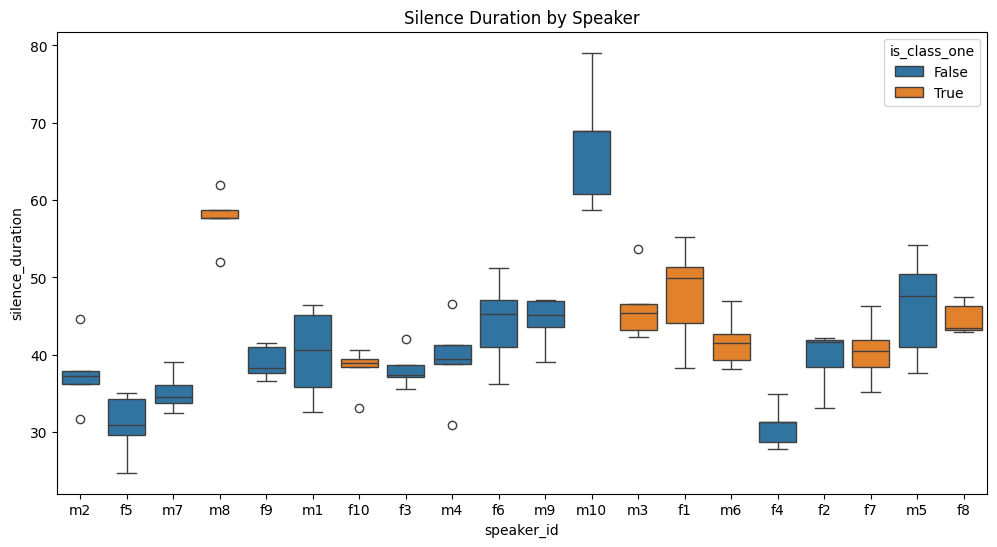

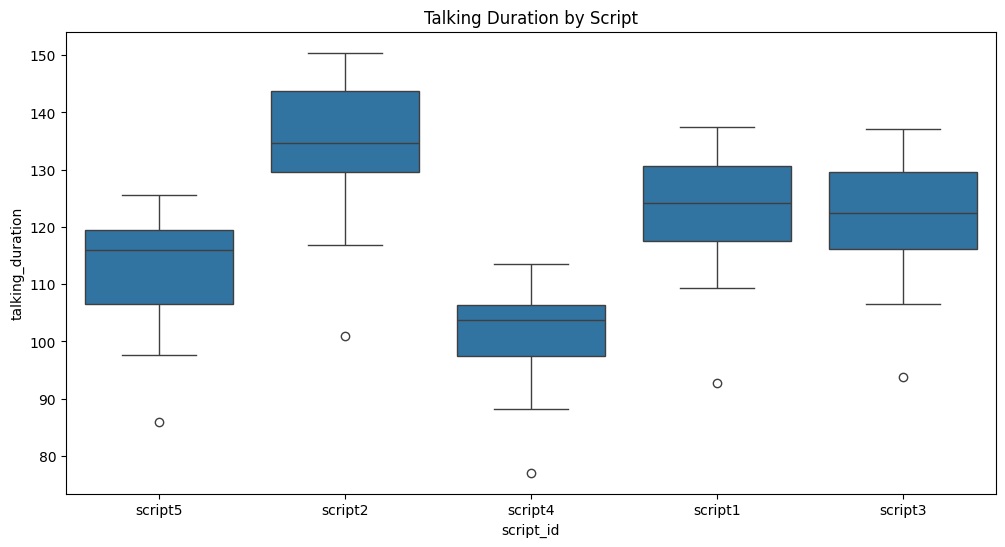

In [6]:
import seaborn as sns

# Distribution of durations
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['duration'], bins=30, kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Distribution by speaker_id
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_df, x='speaker_id', order=metadata_df['speaker_id'].value_counts().index)
plt.title('Number of Samples per Speaker')
plt.xlabel('Speaker ID')
plt.ylabel('Frequency')
plt.show()

# Extract average pixel intensity from spectrograms
def extract_image_features(img_path):
    img = Image.open(img_path).convert('L')  # Ensure grayscale
    img_array = np.array(img)
    avg_intensity = img_array.mean()
    return avg_intensity

metadata_df['avg_intensity'] = None

for idx, row in metadata_df.iterrows():
    img_path = os.path.join(directory, row['filename'].replace('.wav', '.png'))
    metadata_df.at[idx, 'avg_intensity'] = extract_image_features(img_path)

# Avg intensity distribution
plt.figure(figsize=(10, 5))
sns.histplot(metadata_df['avg_intensity'], bins=30, kde=True)
plt.title('Distribution of Average Pixel Intensity in Spectrograms')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
ordered_speakers = sorted(metadata_df['speaker_id'].unique())
sns.boxplot(data=metadata_df,y='duration', x='speaker_id',hue='is_class_one',order=ordered_speakers,)
plt.title('Duration by Speaker')
plt.show()

plt.figure(figsize=(10, 5))
ordered_scripts = sorted(metadata_df['script_id'].unique())
sns.boxplot(data=metadata_df,y='duration', x='script_id',order=ordered_scripts,)
plt.title('Duration by Script')
plt.show()

# Scatter plot to visualize relationship(None?)
plt.figure(figsize=(10, 5))
plt.scatter(metadata_df['duration'], metadata_df['avg_intensity'], alpha=0.5)
plt.title('Correlation between Audio Duration and Spectrogram Intensity')
plt.xlabel('Duration (seconds)')
plt.ylabel('Average Pixel Intensity')
plt.show()

p = metadata_df.pivot(index='speaker_id', columns='script_id', values='avg_intensity').fillna(0)

# Avg Intensity Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(p, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Average Intensity by Speaker and Script')
plt.xlabel('Script ID')
plt.ylabel('Speaker ID')
plt.show()

silence_pivot = metadata_df.pivot(index='speaker_id', columns='script_id', values='silence_duration')
talking_pivot = metadata_df.pivot(index='speaker_id', columns='script_id', values='talking_duration')

#Probably choose one, both seem too much

# Silence duration heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(silence_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Silence Duration'})
plt.title('Silence Duration by Speaker and Script')
plt.show()

# Talking duration heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(talking_pivot, annot=True, cmap='YlGnBu',fmt = '.4g', cbar_kws={'label': 'Talking Duration'})
plt.title('Talking Duration by Speaker and Script')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=metadata_df, x='speaker_id', y='silence_duration',hue='is_class_one')
plt.title('Silence Duration by Speaker')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=metadata_df, x='script_id', y='talking_duration')
plt.title('Talking Duration by Script')
plt.show()

In [2]:
import os
import torch
import torchaudio
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize((0.5,), (0.5,))])
# Dataset class
class AudioSpectrogramDataset(Dataset):
    def __init__(self, slices, labels, sample_rate=16000, transform=None):
        self.slices = slices
        self.labels = labels
        self.sample_rate = sample_rate
        self.transform = transform

    def __getitem__(self, idx):
        waveform = self.slices[idx]
        label = self.labels[idx]

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

    def __len__(self):
        return len(self.slices)

file_paths = []

full_dataset = datasets.ImageFolder(root='../sliced_spectograms/', transform=transform)

images = list(range(len(full_dataset)))
    

# Split into training and testing
train_files, test_files = train_test_split(
    images,
    test_size=0.2,
    random_state=42
)

train_subset = torch.utils.data.Subset(full_dataset, train_files)
test_subset = torch.utils.data.Subset(full_dataset, test_files)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

INPUT_RESOLUTION=128

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * (INPUT_RESOLUTION//4 -2 ) * (INPUT_RESOLUTION//4 - 2), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

PATH = './net.pth'
torch.save(net.state_dict(), PATH)

[1,    20] loss: 0.139
[1,    40] loss: 0.111
[1,    60] loss: 0.132
[1,    80] loss: 0.118
[1,   100] loss: 0.103
[1,   120] loss: 0.103
[2,    20] loss: 0.073
[2,    40] loss: 0.085
[2,    60] loss: 0.080
[2,    80] loss: 0.068
[2,   100] loss: 0.083
[2,   120] loss: 0.077
[3,    20] loss: 0.066
[3,    40] loss: 0.048
[3,    60] loss: 0.073
[3,    80] loss: 0.056
[3,   100] loss: 0.058
[3,   120] loss: 0.047
[4,    20] loss: 0.054
[4,    40] loss: 0.040
[4,    60] loss: 0.045
[4,    80] loss: 0.042
[4,   100] loss: 0.033
[4,   120] loss: 0.041
[5,    20] loss: 0.037
[5,    40] loss: 0.037
[5,    60] loss: 0.031
[5,    80] loss: 0.029
[5,   100] loss: 0.033
[5,   120] loss: 0.033
[6,    20] loss: 0.021
[6,    40] loss: 0.030
[6,    60] loss: 0.018
[6,    80] loss: 0.023
[6,   100] loss: 0.019
[6,   120] loss: 0.033
[7,    20] loss: 0.011
[7,    40] loss: 0.017
[7,    60] loss: 0.024
[7,    80] loss: 0.019
[7,   100] loss: 0.021
[7,   120] loss: 0.015
[8,    20] loss: 0.012
[8,    40] 

In [6]:
net = Net()
PATH = './net.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

# Initialize counters
correct_class_0 = 0  
incorrect_class_0 = 0  
correct_class_1 = 0  
incorrect_class_1 = 0 

# Counters for total samples in each class
total_class_0 = 0
total_class_1 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for label, prediction in zip(labels, predicted):
            if label == 0:
                total_class_0 += 1
                if prediction == 0:
                    correct_class_0 += 1
                else:
                    incorrect_class_0 += 1  # False Acceptance
            elif label == 1:
                total_class_1 += 1
                if prediction == 1:
                    correct_class_1 += 1
                else:
                    incorrect_class_1 += 1  # False Rejection

if total_class_0 > 0:
    far = incorrect_class_0 / total_class_0
else:
    far = None  # handle division by zero if there are no samples for Class 0

if total_class_1 > 0:
    frr = incorrect_class_1 / total_class_1
else:
    frr = None  # handle division by zero if there are no samples for Class 1

print(f"False Acceptance Ratio (FAR): {far:.2%}")
print(f"False Rejection Ratio (FRR): {frr:.2%}")


print(f'Accuracy of the network on the test images: {100 * (correct_class_0+correct_class_1) // (total_class_0+total_class_1)} %')
#Looks like it just rejects everything

False Acceptance Ratio (FAR): 10.34%
False Rejection Ratio (FRR): 18.84%
Accuracy of the network on the test images: 86 %
